In [1]:
import numpy as np
import pandas as pd

import random
random.seed(28)
np.random.seed(28)

import matplotlib.pyplot as plt
from matplotlib_venn import venn2

from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
                             roc_curve, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support)
import os
import copy
from sklearn.metrics import mean_absolute_error
pd.options.display.precision = 15

from collections import defaultdict
import lightgbm as lgb
import xgboost as xgb
import time
from collections import Counter
import datetime
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, KFold, RepeatedKFold, GroupKFold, GridSearchCV, train_test_split, TimeSeriesSplit, RepeatedStratifiedKFold
from sklearn import metrics
import gc
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from bayes_opt import BayesianOptimization
#import eli5
import shap
from IPython.display import HTML
import json

import matplotlib.pyplot as plt
%matplotlib inline
import os
import time
import datetime
import gc
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import metrics
pd.set_option('max_rows', 500)
import re

import os

pd.set_option('display.max_columns', 1000)
pd.set_option('display.max_rows', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.float_format', '{:20,.2f}'.format)
pd.set_option('display.max_colwidth', -1)

np.random.seed(2206)

# Read the data

In [2]:
train = pd.read_csv("../data/training_v2.csv")
samplesubmission = pd.read_csv("../data/samplesubmission.csv")
test = pd.read_csv("../data/unlabeled.csv")
dictionary = pd.read_csv("../data/WiDS Datathon 2020 Dictionary.csv")
solution_template = pd.read_csv("../data/solution_template.csv")

print('train ' , train.shape)
print('test ' , test.shape)
print('samplesubmission ' , samplesubmission.shape)
print('solution_template ' , solution_template.shape)
print('dictionary ' , dictionary.shape)

train  (91713, 186)
test  (39308, 186)
samplesubmission  (3, 2)
solution_template  (39308, 2)
dictionary  (188, 6)


In [3]:
dico = pd.DataFrame(dictionary.T.head(6))
dico.columns=list(dico.loc[dico.index == 'Variable Name'].unstack())
dico = dico.loc[dico.index != 'Variable Name']
dico.columns
train_stat = pd.DataFrame(train.describe())
train_stat2 = pd.concat([dico,train_stat],axis=0)
train_stat2.head(20)

,age,aids,albumin_apache,apache_2_bodysystem,apache_2_diagnosis,apache_3j_bodysystem,apache_3j_diagnosis,apache_4a_hospital_death_prob,apache_4a_icu_death_prob,apache_post_operative,arf_apache,bilirubin_apache,bmi,bun_apache,cirrhosis,creatinine_apache,d1_albumin_max,d1_albumin_min,d1_arterial_pco2_max,d1_arterial_pco2_min,d1_arterial_ph_max,d1_arterial_ph_min,d1_arterial_po2_max,d1_arterial_po2_min,d1_bilirubin_max,d1_bilirubin_min,d1_bun_max,d1_bun_min,d1_calcium_max,d1_calcium_min,d1_creatinine_max,d1_creatinine_min,d1_diasbp_invasive_max,d1_diasbp_invasive_min,d1_diasbp_max,d1_diasbp_min,d1_diasbp_noninvasive_max,d1_diasbp_noninvasive_min,d1_glucose_max,d1_glucose_min,d1_hco3_max,d1_hco3_min,d1_heartrate_max,d1_heartrate_min,d1_hemaglobin_max,d1_hemaglobin_min,d1_hematocrit_max,d1_hematocrit_min,d1_inr_max,d1_inr_min,d1_lactate_max,d1_lactate_min,d1_mbp_invasive_max,d1_mbp_invasive_min,d1_mbp_max,d1_mbp_min,d1_mbp_noninvasive_max,d1_mbp_noninvasive_min,d1_pao2fio2ratio_max,d1_pao2fio2ratio_min,d1_platelets_max,d1_platelets_min,d1_potassium_max,d1_potassium_min,d1_resprate_max,d1_resprate_min,d1_sodium_max,d1_sodium_min,d1_spo2_max,d1_spo2_min,d1_sysbp_invasive_max,d1_sysbp_invasive_min,d1_sysbp_max,d1_sysbp_min,d1_sysbp_noninvasive_max,d1_sysbp_noninvasive_min,d1_temp_max,d1_temp_min,d1_wbc_max,d1_wbc_min,diabetes_mellitus,elective_surgery,encounter_id,ethnicity,fio2_apache,gcs_eyes_apache,gcs_motor_apache,gcs_unable_apache,gcs_verbal_apache,gender,glucose_apache,h1_albumin_max,h1_albumin_min,h1_arterial_pco2_max,h1_arterial_pco2_min,h1_arterial_ph_max,h1_arterial_ph_min,h1_arterial_po2_max,h1_arterial_po2_min,h1_bilirubin_max,h1_bilirubin_min,h1_bun_max,h1_bun_min,h1_calcium_max,h1_calcium_min,h1_creatinine_max,h1_creatinine_min,h1_diasbp_invasive_max,h1_diasbp_invasive_min,h1_diasbp_max,h1_diasbp_min,h1_diasbp_noninvasive_max,h1_diasbp_noninvasive_min,h1_glucose_max,h1_glucose_min,h1_hco3_max,h1_hco3_min,h1_heartrate_max,h1_heartrate_min,h1_hemaglobin_max,h1_hemaglobin_min,h1_hematocrit_max,h1_hematocrit_min,h1_inr_max,h1_inr_min,h1_lactate_max,h1_lactate_min,h1_mbp_invasive_max,h1_mbp_invasive_min,h1_mbp_max,h1_mbp_min,h1_mbp_noninvasive_max,h1_mbp_noninvasive_min,h1_pao2fio2ratio_max,h1_pao2fio2ratio_min,h1_platelets_max,h1_platelets_min,h1_potassium_max,h1_potassium_min,h1_resprate_max,h1_resprate_min,h1_sodium_max,h1_sodium_min,h1_spo2_max,h1_spo2_min,h1_sysbp_invasive_max,h1_sysbp_invasive_min,h1_sysbp_max,h1_sysbp_min,h1_sysbp_noninvasive_max,h1_sysbp_noninvasive_min,h1_temp_max,h1_temp_min,h1_wbc_max,h1_wbc_min,heart_rate_apache,height,hematocrit_apache,hepatic_failure,hospital_admit_source,hospital_death,hospital_id,icu_admit_source,icu_admit_type,icu_id,icu_stay_type,icu_type,immunosuppression,intubated_apache,leukemia,lymphoma,map_apache,paco2_apache,paco2_for_ph_apache,pao2_apache,patient_id,ph_apache,pre_icu_los_days,pred,readmission_status,resprate_apache,sodium_apache,solid_tumor_with_metastasis,temp_apache,urineoutput_apache,ventilated_apache,wbc_apache,weight
Category,demographic,APACHE comorbidity,APACHE covariate,APACHE grouping,APACHE covariate,APACHE grouping,APACHE covariate,APACHE prediction,APACHE prediction,APACHE covariate,APACHE covariate,APACHE covariate,demographic,APACHE covariate,APACHE comorbidity,APACHE covariate,labs,labs,labs blood gas,labs blood gas,labs blood gas,labs blood gas,labs blood gas,labs blood gas,labs,labs,labs,labs,labs,labs,labs,labs,vitals,vitals,vitals,vitals,vitals,vitals,labs,labs,labs,labs,vitals,vitals,labs,labs,labs,labs,labs,labs,labs,labs,vitals,vitals,vitals,vitals,vitals,vitals,labs blood gas,labs blood gas,labs,labs,labs,labs,vitals,vitals,labs,labs,vitals,vitals,vitals,vitals,vitals,vitals,vitals,vitals,vitals,vitals,labs,labs,APACHE comorbidity,demographic,identifier,demographic,APACHE covariate,APACHE covariate,APACHE covariate,APACHE covariate,APACHE covariate,demographic,APACHE covariate,labs,labs,labs blood gas,labs blood gas,labs blood gas,labs blood gas

# OverView of the dataset

In [4]:
train_stat2.T.head(200)

,Category,Unit of Measure,Data Type,Description,Example,count,mean,std,min,25%,50%,75%,max
age,demographic,Years,numeric,The age of the patient on unit admission,None,"87,485.00",62.31,16.78,16.00,52.00,65.00,75.00,89.00
aids,APACHE comorbidity,None,binary,Whether the patient has a definitive diagnosis of acquired immune deficiency syndrome (AIDS) (not HIV positive alone),1,"90,998.00",0.00,0.03,0.00,0.00,0.00,0.00,1.00
albumin_apache,APACHE covariate,g/L,numeric,The albumin concentration measured during the first 24 hours which results in the highest APACHE III score,30,"37,334.00",2.90,0.68,1.20,2.40,2.90,3.40,4.60
apache_2_bodysystem,APACHE grouping,None,string,Admission diagnosis group for APACHE II,Respiratory,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
apache_2_diagnosis,APACHE covariate,None,string,The APACHE II diagnosis for the ICU admission,308,"90,051.00",185.40,86.05,101.00,113.00,122.00,301.00,308.00
apache_3j_bodysystem,APACHE grouping,None,string,Admission diagnosis group for APACHE III,Cardiovascular,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
apache_3j_diagnosis,APACHE covariate,None,string,The APACHE III-J sub-diagnosis code which best describes the reason for the ICU admission,1405,"90,612.00",558.22,463.27,0.01,203.01,409.02,703.03,"2,201.05"
apache_4a_hospital_death_prob,APACHE prediction,None,numeric,"The APACHE IVa probabilistic prediction of in-hospital mortality for the patient which utilizes the APACHE III score and other covariates, including diagnosis.",0.31,"83,766.00",0.09,0.25,-1.00,0.02,0.05,0.13,0.99
apache_4a_icu_death_prob,APACHE prediction,None,numeric,"The APACHE IVa probabilistic prediction of in ICU mortality for the patient which utilizes the APACHE III score and other covariates, including diagnosis",0.24,"83,766.00",0.04,0.22,-1.00,0.01,0.02,0.06,0.97
apache_post_operative,APACHE covariate,None,binary,"The APACHE operative status; 1 for post-operative, 0 for non-operative",1,"91,713.00",0.20,0.40,0.00,0.00,0.00,0.00,1.00


## EDA

In [5]:
# Missing Values
train.isna().sum()

encounter_id                     0    
patient_id                       0    
hospital_id                      0    
hospital_death                   0    
age                              4228 
bmi                              3429 
elective_surgery                 0    
ethnicity                        1395 
gender                           25   
height                           1334 
hospital_admit_source            21409
icu_admit_source                 112  
icu_id                           0    
icu_stay_type                    0    
icu_type                         0    
pre_icu_los_days                 0    
readmission_status               0    
weight                           2720 
albumin_apache                   54379
apache_2_diagnosis               1662 
apache_3j_diagnosis              1101 
apache_post_operative            0    
arf_apache                       715  
bilirubin_apache                 58134
bun_apache                       19262
creatinine_apache        

## Functions

In [6]:
# function to evaluate the score of our model
def eval_auc(pred,real):
    false_positive_rate, recall, thresholds = roc_curve(real, pred)
    roc_auc = auc(false_positive_rate, recall)
    return roc_auc    

In [7]:
# a wrapper class  that we can have the same ouput whatever the model we choose
class Base_Model(object):
    
    def __init__(self, train_df, test_df, features, categoricals=[], n_splits=5, verbose=True,ps={}):
        self.train_df = train_df
        self.test_df = test_df
        self.features = features
        self.n_splits = n_splits
        self.categoricals = categoricals
        self.target = 'hospital_death'
        self.cv = self.get_cv()
        self.verbose = verbose
#         self.params = self.get_params()
        self.params = self.set_params(ps)
        self.y_pred, self.score, self.model , self.oof_pred = self.fit()
        
    def train_model(self, train_set, val_set):
        raise NotImplementedError
        
    def get_cv(self):
        cv = StratifiedKFold(n_splits=self.n_splits, shuffle=True, random_state=42)
        return cv.split(self.train_df, self.train_df[self.target])
    
    def get_params(self):
        raise NotImplementedError
        
    def convert_dataset(self, x_train, y_train, x_val, y_val):
        raise NotImplementedError
        
    def convert_x(self, x):
        return x
        
    def fit(self):
        oof_pred = np.zeros((len(self.train_df), ))
        y_pred = np.zeros((len(self.test_df), ))
        for fold, (train_idx, val_idx) in enumerate(self.cv):
            x_train, x_val = self.train_df[self.features].iloc[train_idx], self.train_df[self.features].iloc[val_idx]
            y_train, y_val = self.train_df[self.target][train_idx], self.train_df[self.target][val_idx]
            train_set, val_set = self.convert_dataset(x_train, y_train, x_val, y_val)
            model = self.train_model(train_set, val_set)
            conv_x_val = self.convert_x(x_val)
            oof_pred[val_idx] = model.predict(conv_x_val).reshape(oof_pred[val_idx].shape)
            x_test = self.convert_x(self.test_df[self.features])
            y_pred += model.predict(x_test).reshape(y_pred.shape) / self.n_splits

            print('Partial score of fold {} is: {}'.format(fold,eval_auc(oof_pred[val_idx],y_val) ))
        #print(oof_pred, self.train_df[self.target].values)
        loss_score = eval_auc(oof_pred,self.train_df[self.target].values) 
        if self.verbose:
            print('Our oof AUC score is: ', loss_score)
        return y_pred, loss_score, model , oof_pred

In [8]:
#we choose to try a LightGbM using the Base_Model class
class Lgb_Model(Base_Model):
    
    def train_model(self, train_set, val_set):
        verbosity = 100 if self.verbose else 0
        return lgb.train(self.params, train_set, valid_sets=[train_set, val_set], verbose_eval=verbosity)
        
    def convert_dataset(self, x_train, y_train, x_val, y_val):
        train_set = lgb.Dataset(x_train, y_train, categorical_feature=self.categoricals)
        val_set   = lgb.Dataset(x_val,    y_val,  categorical_feature=self.categoricals)
        return train_set, val_set
        
    def get_params(self):
        params = {'n_estimators':5000,
                    'boosting_type': 'gbdt',
                    'objective': 'binary',
                    'metric': 'auc',
                    'subsample': 0.75,
                    'subsample_freq': 1,
                    'learning_rate': 0.1,
                    'feature_fraction': 0.9,
                    'max_depth': 15,
                    'lambda_l1': 1,  
                    'lambda_l2': 1,
                    'early_stopping_rounds': 100,
                    #'is_unbalance' : True ,
                    'scale_pos_weight' : 3
                  
                    }
        return params
    def set_params(self,ps={}):
        params = self.get_params()
        if 'subsample_freq' in ps:
            params['subsample_freq']=int(ps['subsample_freq'])
            params['learning_rate']=ps['learning_rate']
            params['feature_fraction']=ps['feature_fraction']
            params['lambda_l1']=ps['lambda_l1']
            params['lambda_l2']=ps['lambda_l2']
            params['scale_pos_weight']=ps['scale_pos_weight']
            params['max_depth']=int(ps['max_depth'])
        
        return params  

In [9]:
def plot_importances(importances_):
    mean_gain = importances_[['gain', 'feature']].groupby('feature').mean()
    importances_['mean_gain'] = importances_['feature'].map(mean_gain['gain'])
    plt.figure(figsize=(18, 44))
    data_imp = importances_.sort_values('mean_gain', ascending=False)
    sns.barplot(x='gain', y='feature', data=data_imp[:300])
    plt.tight_layout()
    plt.savefig('importances-lgb-v4.png')
    plt.show()

## Feature Engineering 

In [10]:
#we are going to drop these columns because we dont want our ML model to be bias toward these consideration
#(we also remove the target and the ids.)
to_drop = ['gender','ethnicity' ,'encounter_id', 'patient_id',  'hospital_death']

# this is a list of features that look like to be categorical
categoricals_features = ['hospital_id','ethnicity','gender','hospital_admit_source','icu_admit_source',
                         'icu_stay_type','icu_type','apache_3j_bodysystem','apache_2_bodysystem']
categoricals_features = [col for col in categoricals_features if col not in to_drop]

# this is the list of all input feature we would like our model to use 
features = [col for col in train.columns if col not in to_drop ]
print('numerber of features ' , len(features))
print('shape of train / test ', train.shape , test.shape)

numerber of features  181
shape of train / test  (91713, 186) (39308, 186)


categorical feature need to be transform to numeric for mathematical purpose.
different technics of categorical encoding exists here we will rely on our model API to deal with categorical
still we need to encode each categorical value to an id , for this purpose we use LabelEncoder


In [11]:
# categorical feature need to be transform to numeric for mathematical purpose.
# different technics of categorical encoding exists here we will rely on our model API to deal with categorical
# still we need to encode each categorical value to an id , for this purpose we use LabelEncoder

print('Transform all String features to category.\n')
for usecol in categoricals_features:
    train[usecol] = train[usecol].astype('str')
    test[usecol] = test[usecol].astype('str')
    
    #Fit LabelEncoder
    le = LabelEncoder().fit(
            np.unique(train[usecol].unique().tolist()+
                      test[usecol].unique().tolist()))

    #At the end 0 will be used for dropped values
    train[usecol] = le.transform(train[usecol])+1
    test[usecol]  = le.transform(test[usecol])+1
    
    train[usecol] = train[usecol].replace(np.nan, 0).astype('int').astype('category')
    test[usecol]  = test[usecol].replace(np.nan, 0).astype('int').astype('category')

Transform all String features to category.



## Adversarial Validation

The main idea of adversarial validation is to detect shift/drift in the different features between 2 datasets.

We usually train a model on past data to forecast future data so it can happened that these futures datas have a distribution that is no longer in line with the data we used for training, or maybe we train on some hospital datas and apply our model on other hospital ?

You can detect drift by statistical test (like t-test) but here we will do it by training a machine learning model and check if the model can figure out if the data is from the train or test set. If it can, this means that the test data comes from another distribution compare to the train data and then you have to check the distribution of the most important features that are likely to be different between train and test.

In [12]:
def adversarial_validation(train, test, features):
    tr_data   = train.copy()
    tst_data = test.copy()
    tr_data['target']  = 0 
    tst_data['target'] = 1
    av_data = pd.concat([tr_data, tst_data], axis = 0)
    av_data.reset_index(drop = True)        
    params = {
            'learning_rate': 0.1, 
            'seed': 50,
            'objective':'binary',
            'boosting_type':'gbdt',
            'metric': 'auc',
        }    
    # define a KFold strategy
    kf = StratifiedKFold(n_splits = 5, shuffle=True, random_state=42)
    target = 'target'
    oof_pred = np.zeros(len(av_data))
    important_features = pd.DataFrame()
    fold_auc = []    
    
    for fold, (tr_ind, val_ind) in enumerate(kf.split(av_data, av_data[target])) :
        print('Fold {}'.format(fold + 1))
        x_train, x_val = av_data[features].iloc[tr_ind], av_data[features].iloc[val_ind]
        y_train, y_val = av_data[target].iloc[tr_ind], av_data[target].iloc[val_ind]
        train_set = lgb.Dataset(x_train, y_train)
        val_set   = lgb.Dataset(x_val, y_val)
        
        model = lgb.train(params, train_set, num_boost_round = 1000, early_stopping_rounds = 20, valid_sets = [train_set, val_set], verbose_eval = 100)
        
        fold_importance = pd.DataFrame()
        fold_importance['feature'] = features
        fold_importance['gain'] = model.feature_importance()
        important_features = pd.concat([important_features, fold_importance], axis = 0)
        
        oof_pred[val_ind] = model.predict(x_val)
        fold_auc.append(metrics.roc_auc_score(y_train, model.predict(x_train)))
        
    print('Our mean train roc auc score is :', np.mean(fold_auc))
    print('Our oof roc auc score is :', metrics.roc_auc_score(av_data[target], oof_pred))
    return important_features

In [13]:
# run the adversatial model with all the feature we used :
    
adversarial_features = adversarial_validation(train, test, features)

Fold 1
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[8]	training's auc: 0.999923	valid_1's auc: 0.999668
Fold 2
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[12]	training's auc: 0.999946	valid_1's auc: 0.999742
Fold 3
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[19]	training's auc: 0.999973	valid_1's auc: 0.999695
Fold 4
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[11]	training's auc: 0.999943	valid_1's auc: 0.999708
Fold 5
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[2]	training's auc: 0.999837	valid_1's auc: 0.999744
Our mean train roc auc score is : 0.9999243769293862
Our oof roc auc score is : 0.9980863280150195


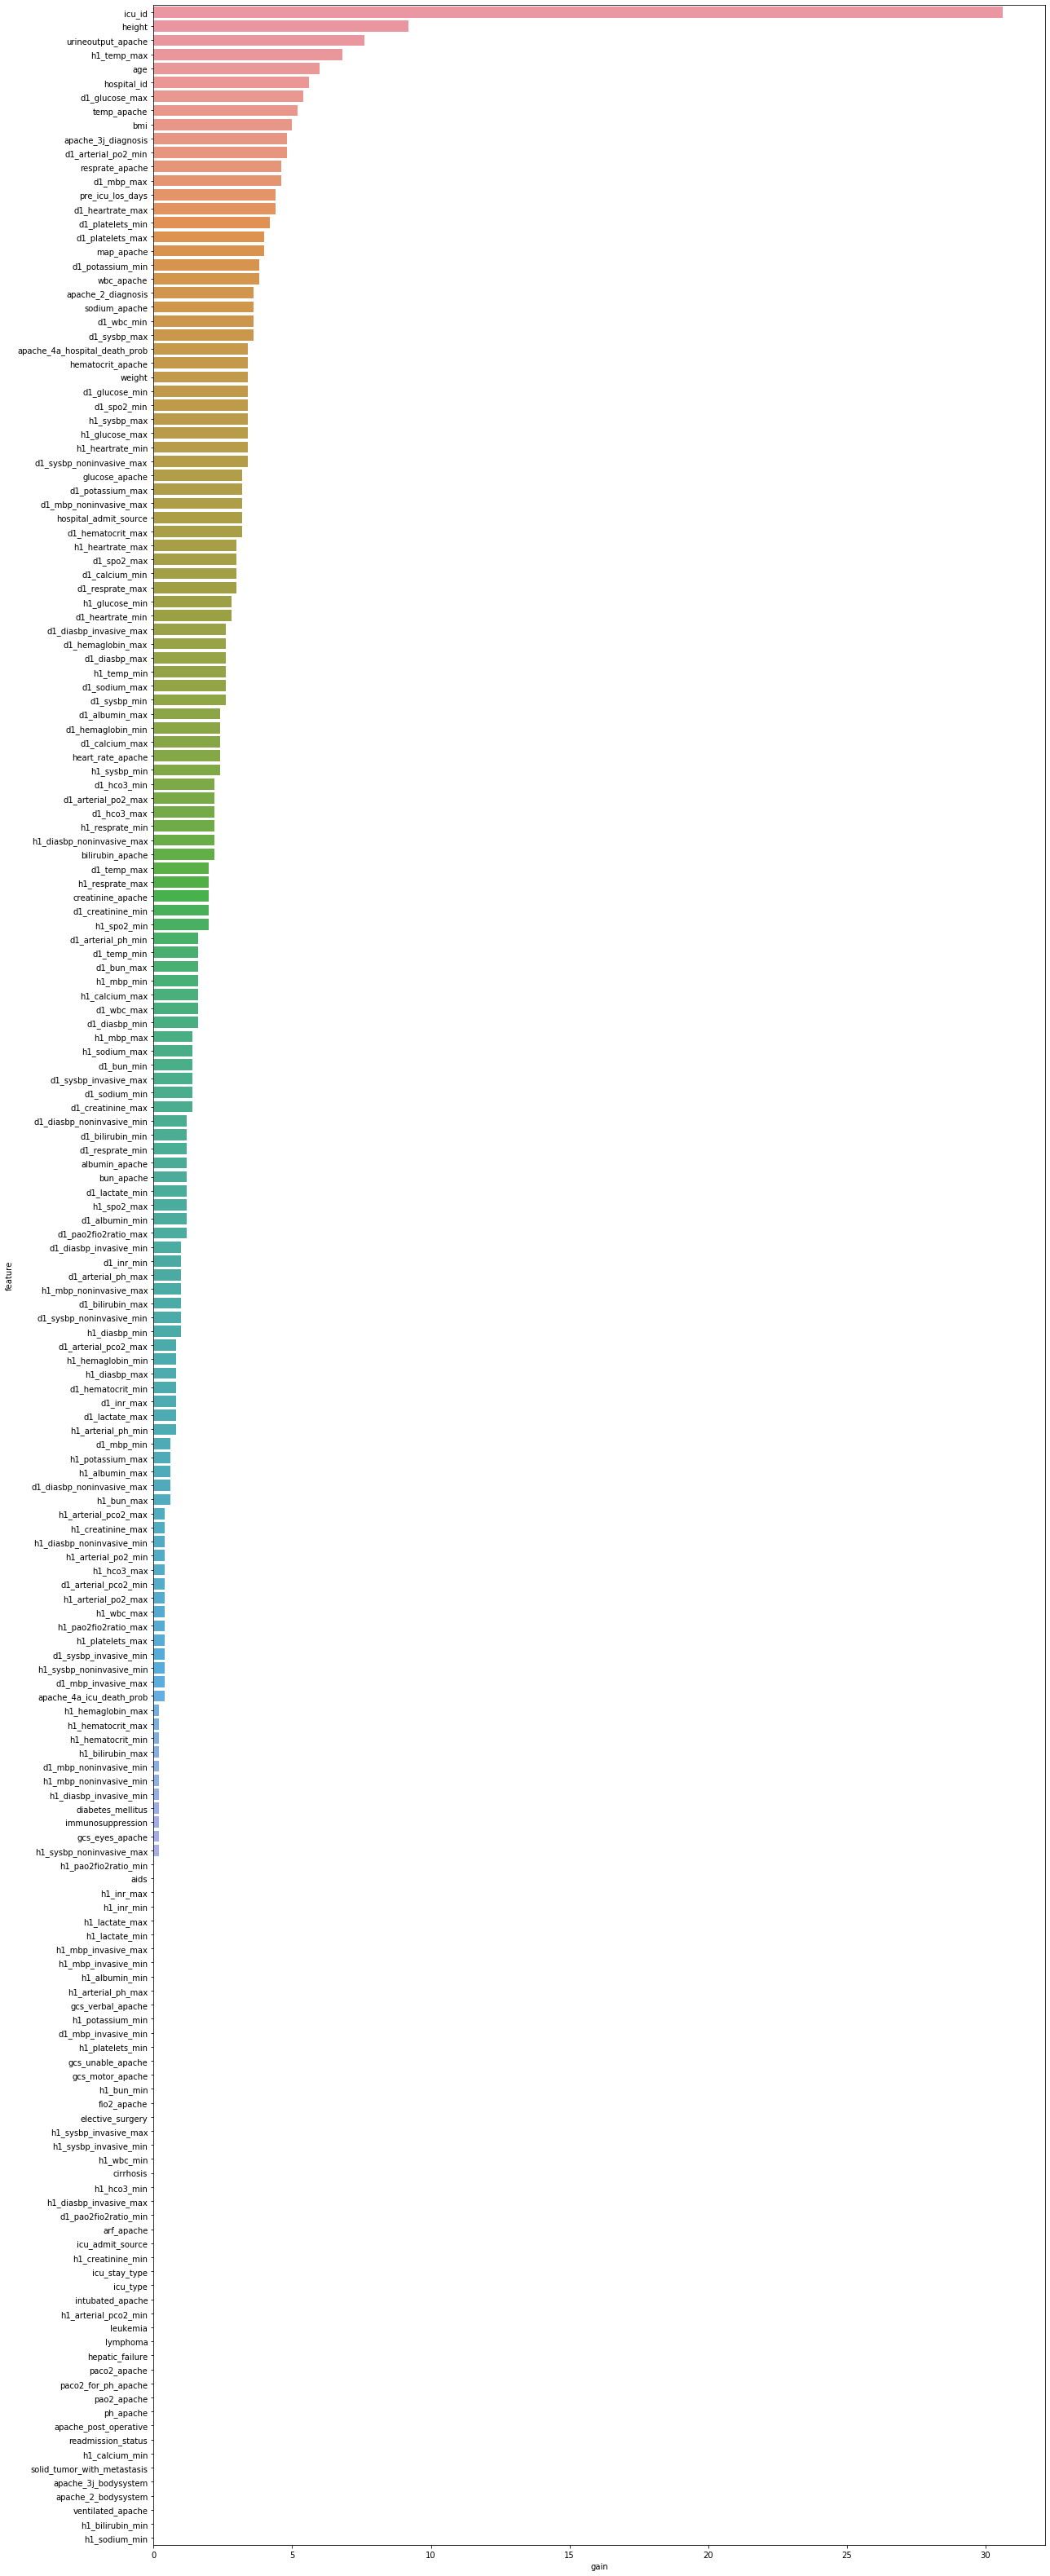

In [14]:
# AUC is almost perfect so we can expect that some feature are perfectly different between train / test

adversarial_features = adversarial_features[['gain', 'feature']].groupby('feature').mean().reset_index()
adversarial_features= adversarial_features.sort_values('gain', ascending=False)

plot_importances(adversarial_features)

icu_id 0 gain : 30.6


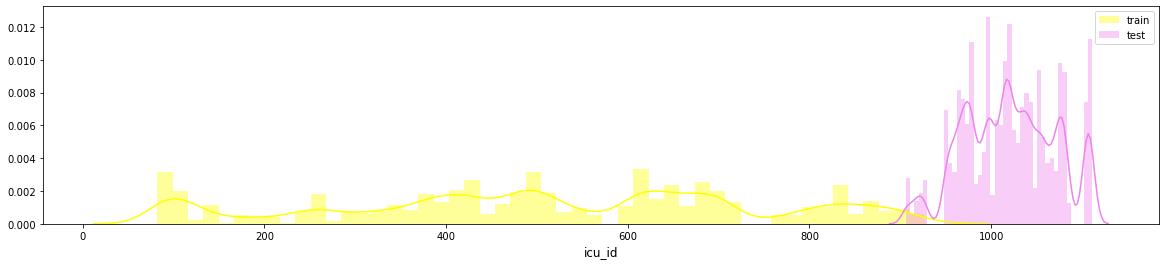

height 1 gain : 9.2


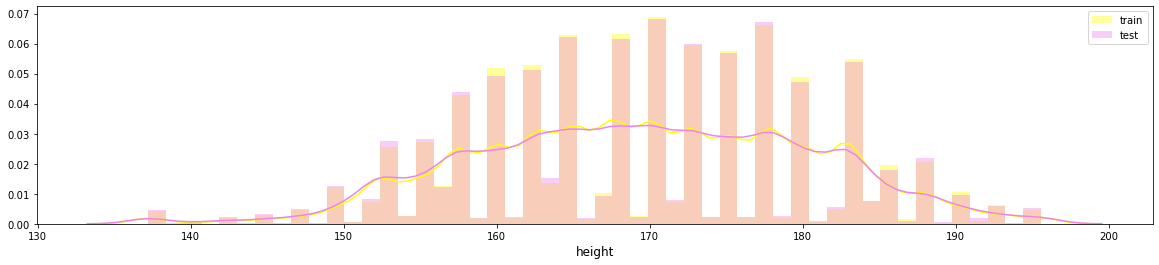

urineoutput_apache 2 gain : 7.6


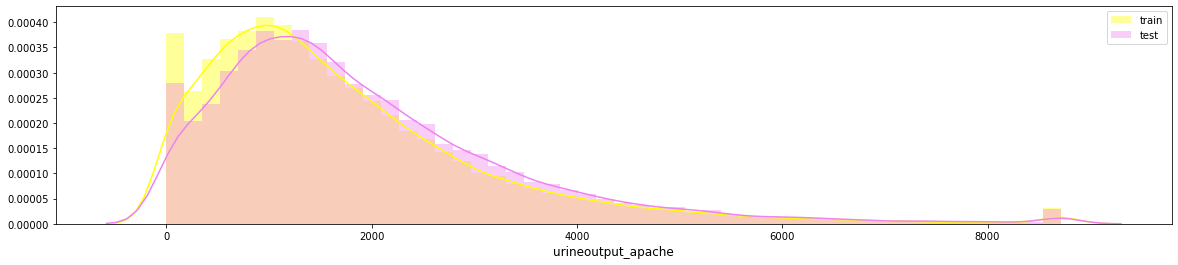

h1_temp_max 3 gain : 6.8


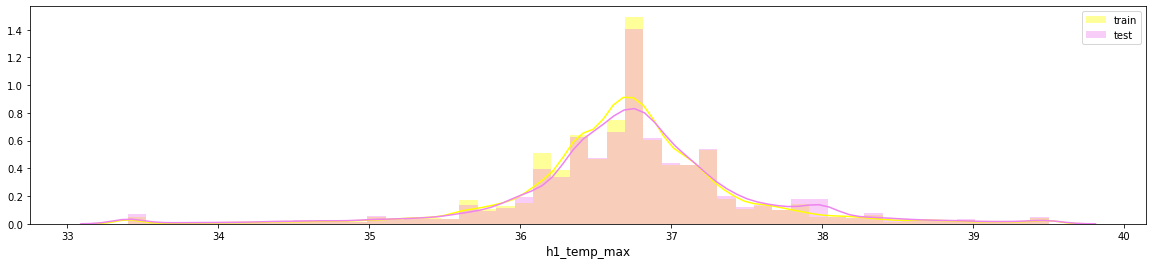

age 4 gain : 6.0


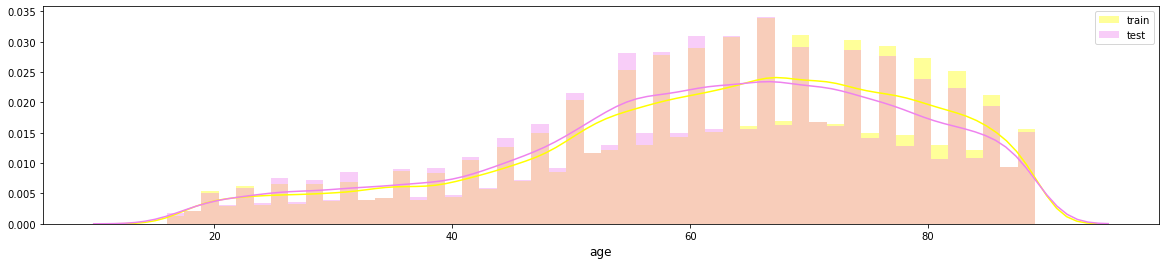

hospital_id 5 gain : 5.6


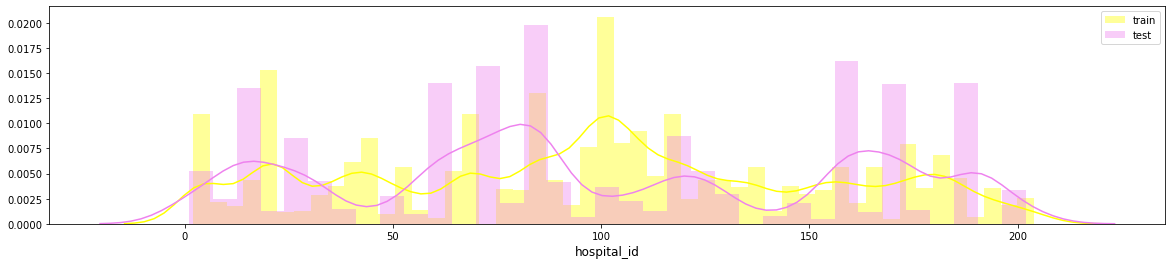

d1_glucose_max 6 gain : 5.4


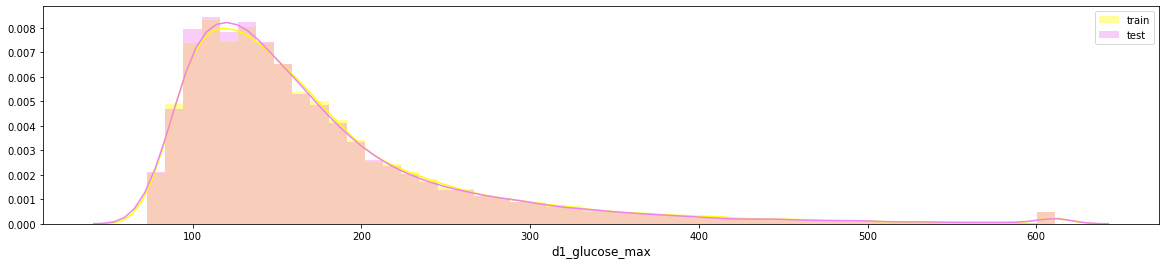

temp_apache 7 gain : 5.2


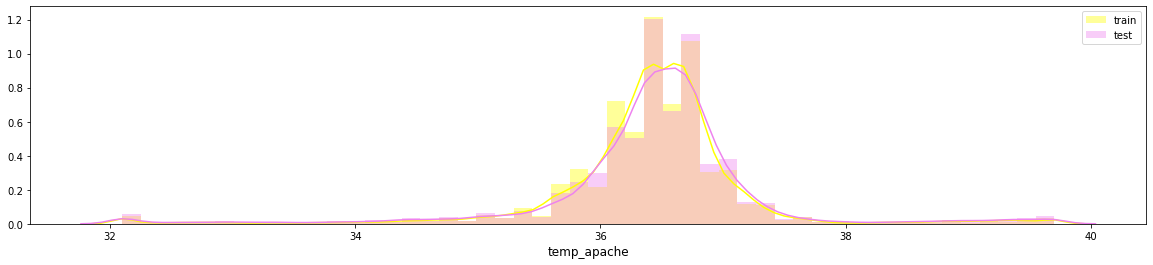

bmi 8 gain : 5.0


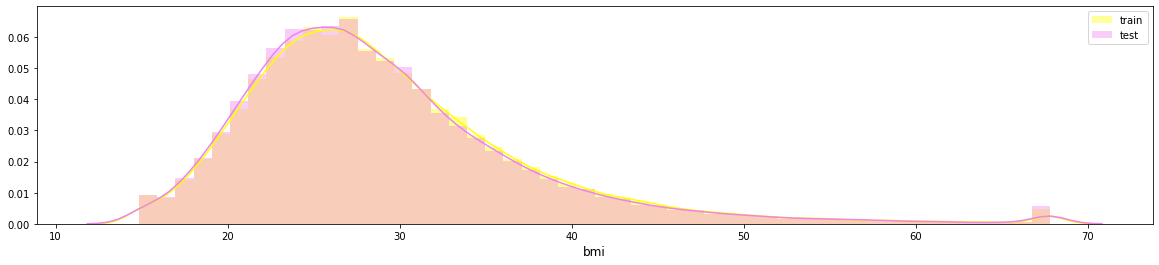

apache_3j_diagnosis 9 gain : 4.8


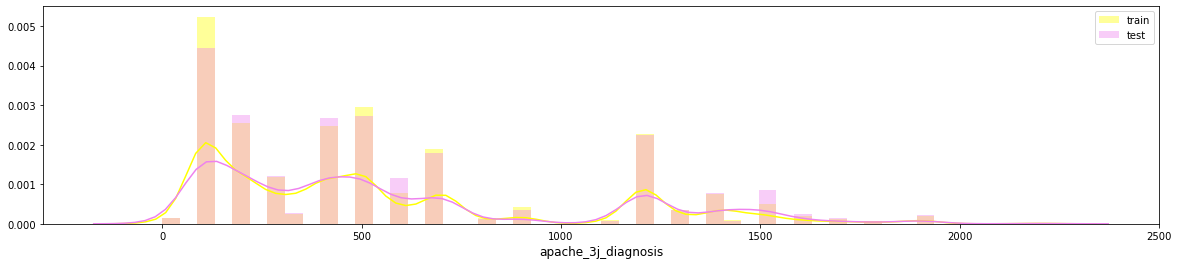

In [15]:
# So icu_id columns seems to be the feature that dominate the feature importance for the adversarial 
# validation model, so it is likely to be totally different between train and test, 
# lets check the distribution of the top features :

def plot_differente_between_train_test(adversarial_features):
    import warnings
    warnings.filterwarnings("ignore")
    warnings.simplefilter(action='ignore', category=UserWarning)
    i=0
    for index, row in adversarial_features.sort_values(by=['gain'],ascending=False).iterrows():  
        column=row['feature']
        if i< 10:
                print(column,i,"gain :",row['gain'])
                df1      = train.copy()
                df2      = test.copy()

                fig = plt.figure(figsize=(20,4))
                sns.distplot(df1[column].dropna(),  color='yellow', label='train', kde=True); 
                sns.distplot(df2[column].dropna(),  color='violet', label='test', kde=True); 
                fig=plt.legend(loc='best')
                plt.xlabel(column, fontsize=12);
                plt.show()
                i=i+1

plot_differente_between_train_test(adversarial_features)

In [16]:
# it is .... Let's remove icu_id and see the results ..
adversarial_features2 = adversarial_validation(train, test, [ f for f in features if f not in ['icu_id'] ])

Fold 1
Training until validation scores don't improve for 20 rounds
[100]	training's auc: 0.999758	valid_1's auc: 0.999626
Early stopping, best iteration is:
[135]	training's auc: 0.999906	valid_1's auc: 0.999644
Fold 2
Training until validation scores don't improve for 20 rounds
[100]	training's auc: 0.999738	valid_1's auc: 0.999572
Early stopping, best iteration is:
[90]	training's auc: 0.9997	valid_1's auc: 0.999575
Fold 3
Training until validation scores don't improve for 20 rounds
[100]	training's auc: 0.999754	valid_1's auc: 0.999687
Early stopping, best iteration is:
[96]	training's auc: 0.999736	valid_1's auc: 0.999688
Fold 4
Training until validation scores don't improve for 20 rounds
[100]	training's auc: 0.999759	valid_1's auc: 0.999645
[200]	training's auc: 0.999993	valid_1's auc: 0.999676
Early stopping, best iteration is:
[204]	training's auc: 0.999994	valid_1's auc: 0.999677
Fold 5
Training until validation scores don't improve for 20 rounds
[100]	training's auc: 0.99977

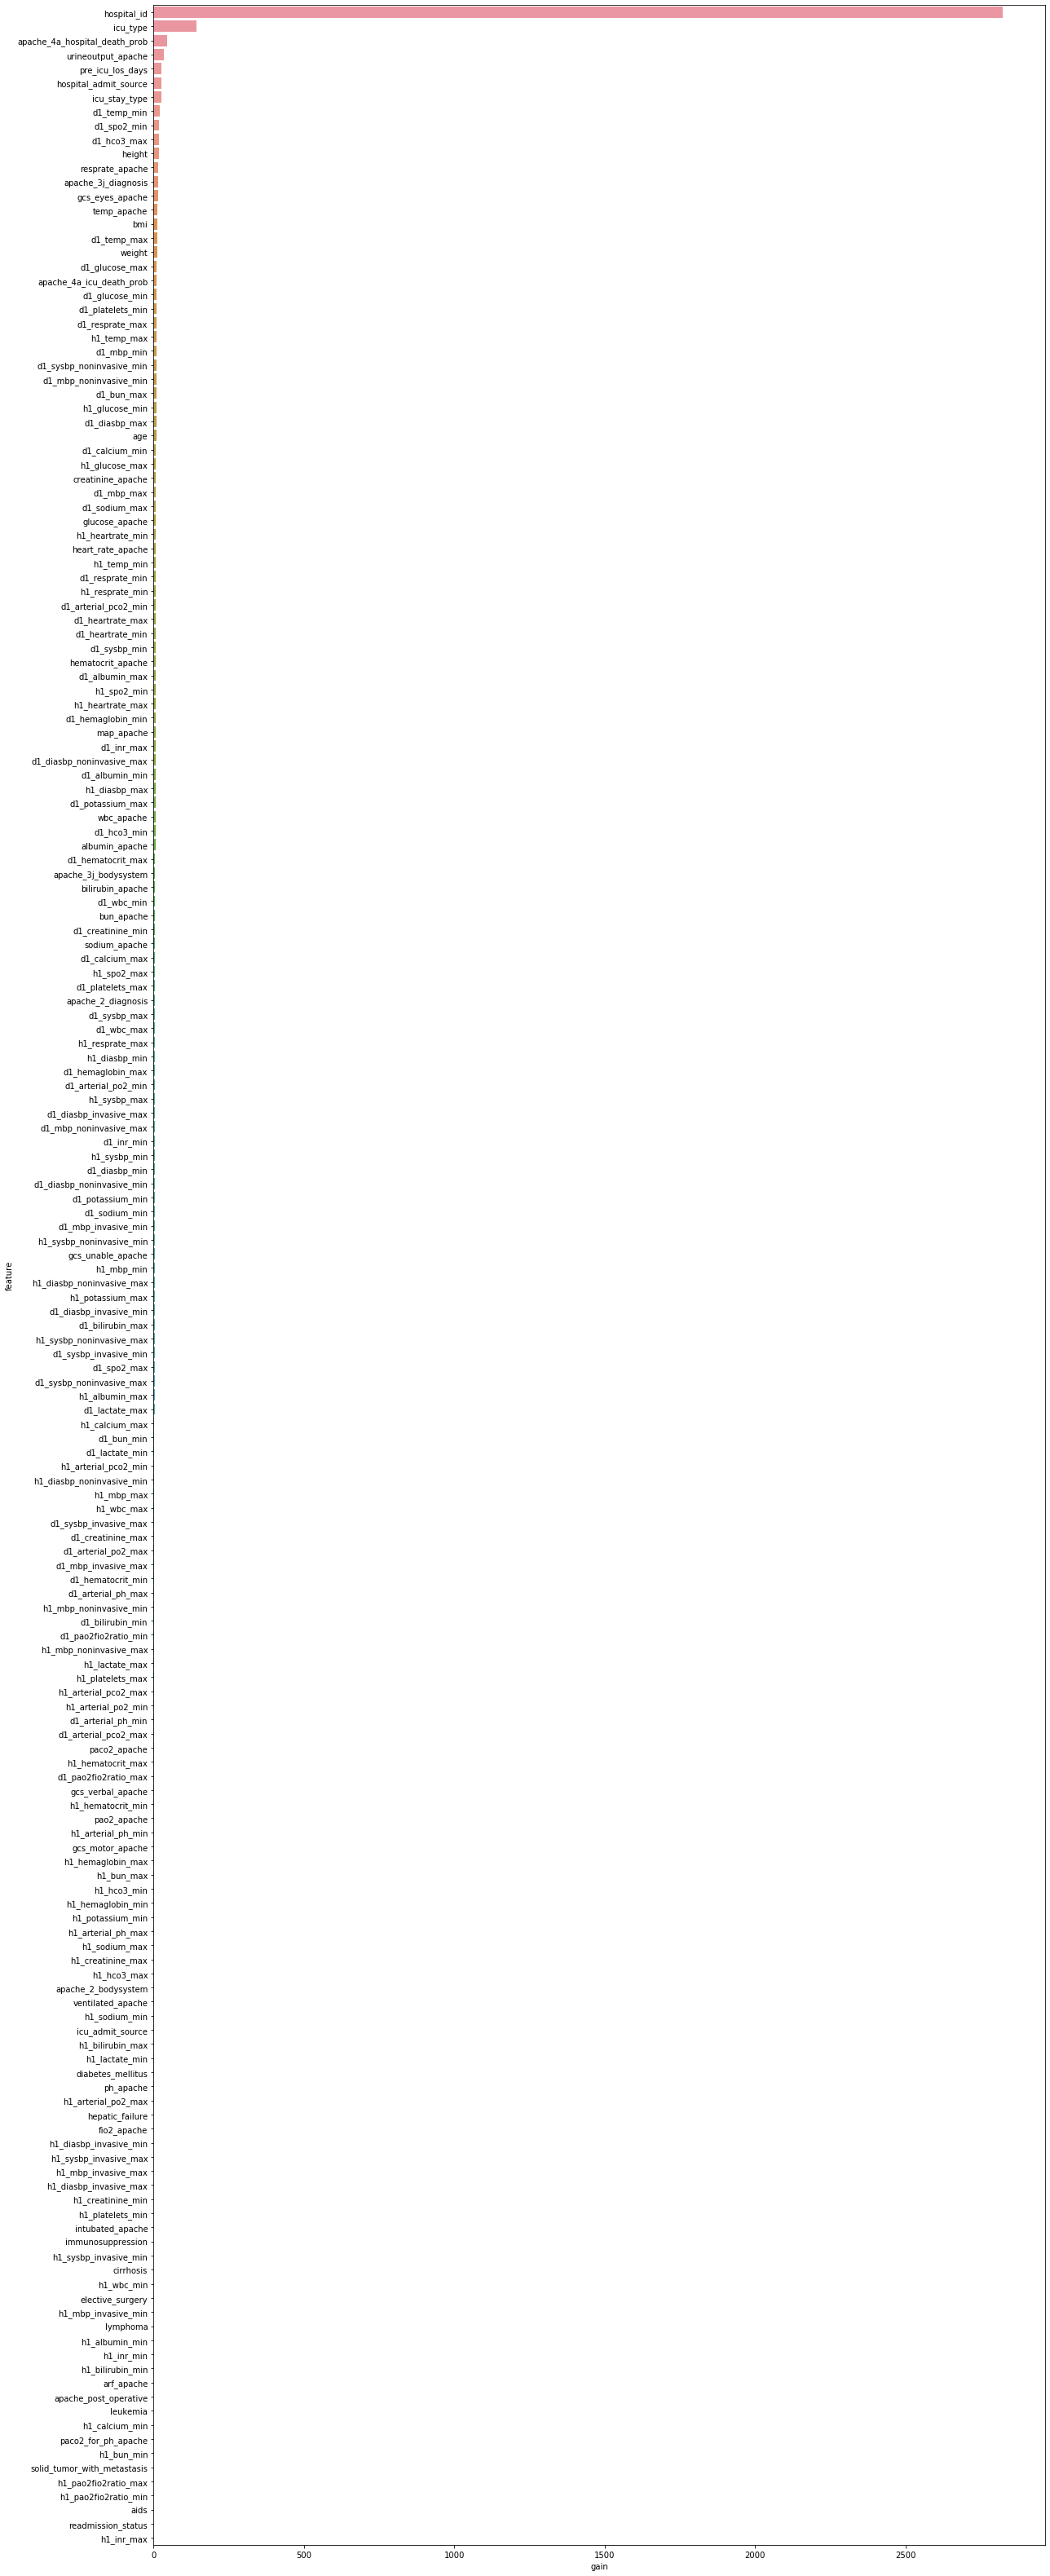

In [17]:
# Let`s check again the difference between train / test

adversarial_features2 = adversarial_features2[['gain', 'feature']].groupby('feature').mean().reset_index()
adversarial_features2= adversarial_features2.sort_values('gain', ascending=False)

plot_importances(adversarial_features2)

hospital_id 0 gain : 2822.0


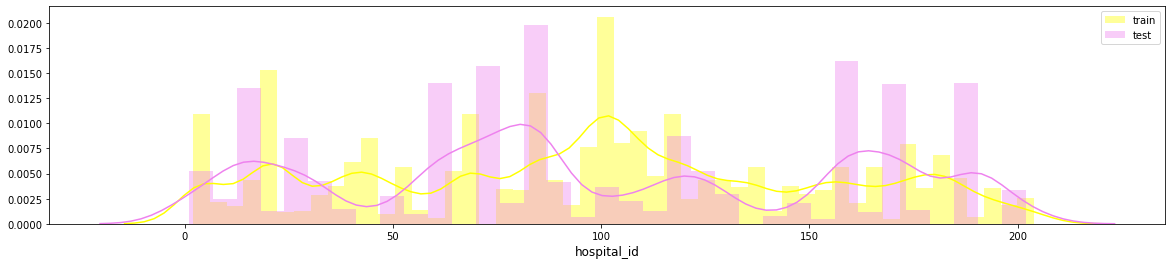

icu_type 1 gain : 142.8


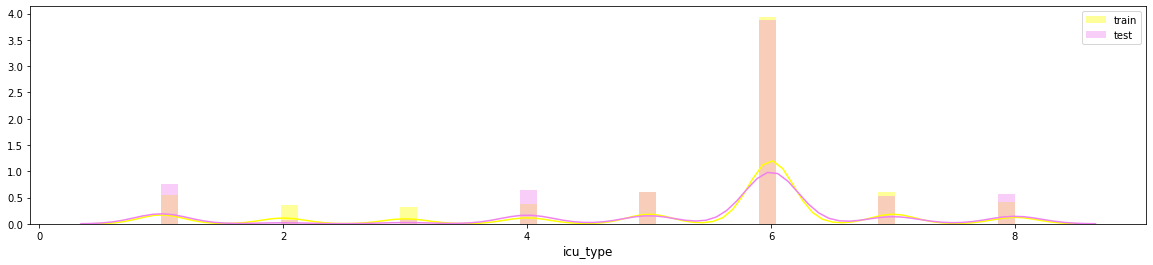

apache_4a_hospital_death_prob 2 gain : 44.4


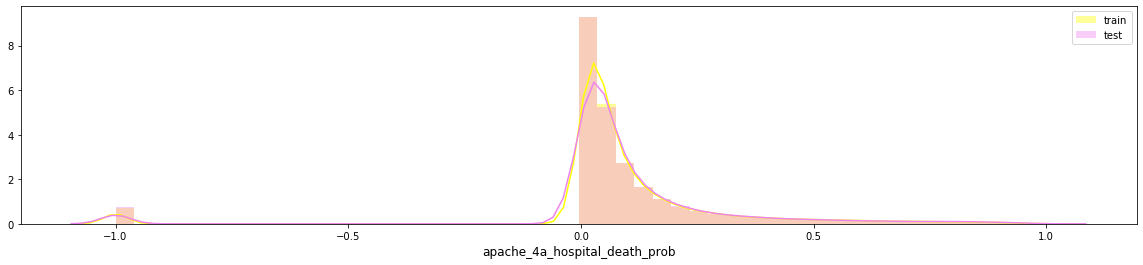

urineoutput_apache 3 gain : 35.2


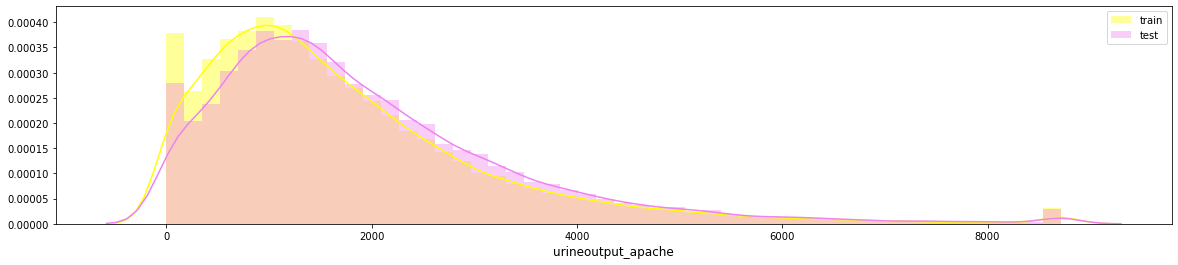

pre_icu_los_days 4 gain : 27.4


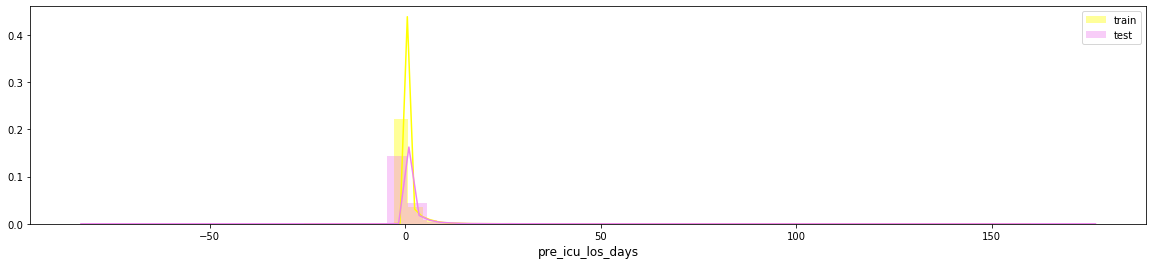

hospital_admit_source 5 gain : 26.0


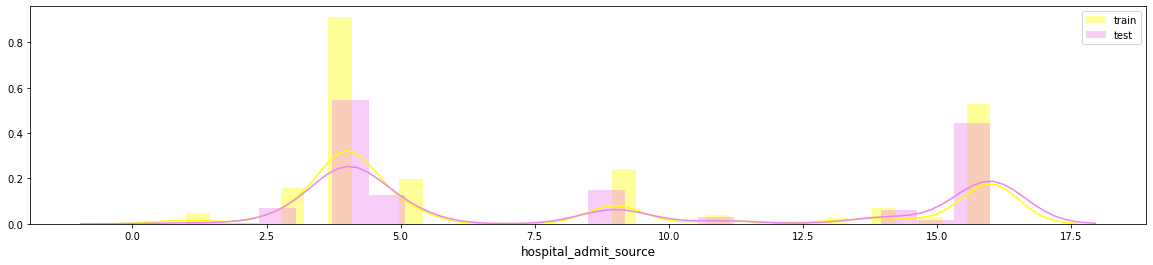

icu_stay_type 6 gain : 25.4


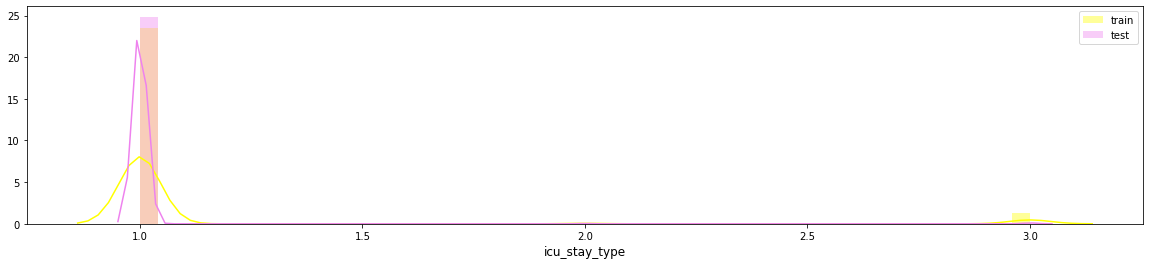

d1_temp_min 7 gain : 21.8


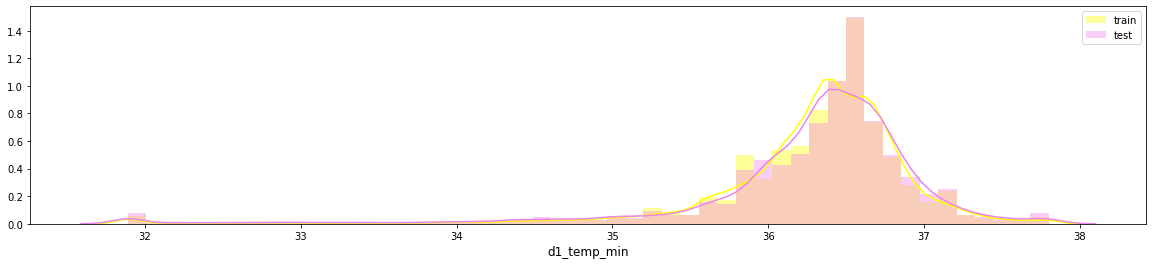

d1_spo2_min 8 gain : 19.4


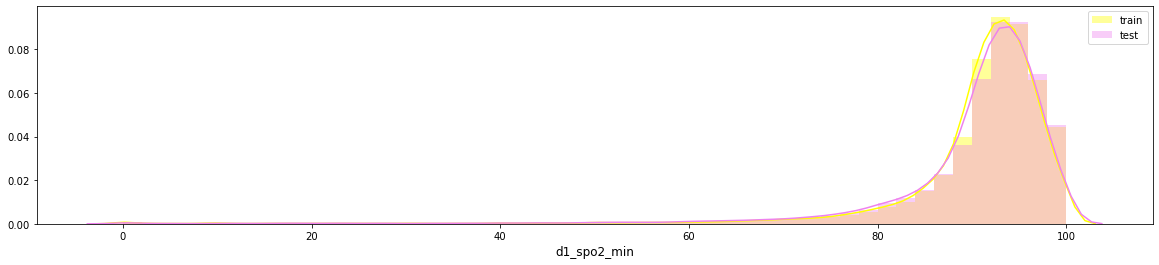

d1_hco3_max 9 gain : 18.8


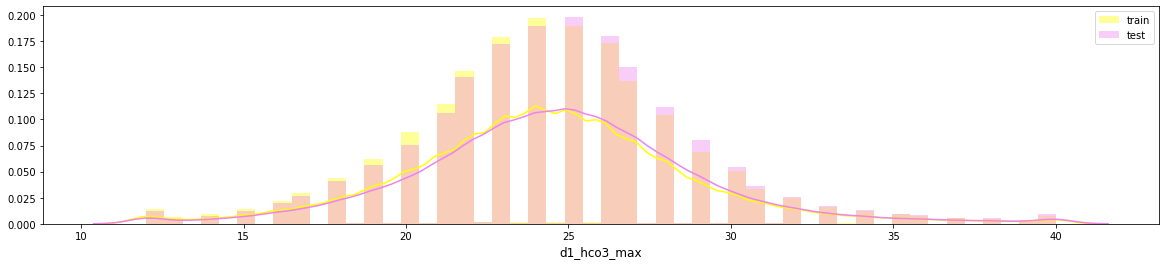

In [18]:
plot_differente_between_train_test(adversarial_features2)

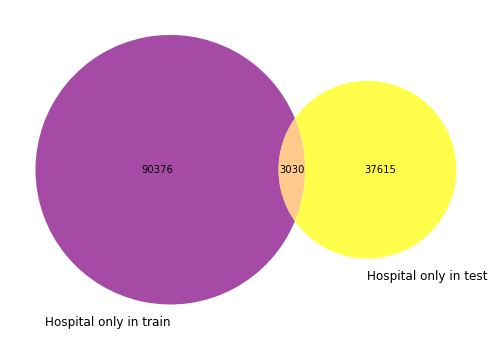

In [19]:
# hospital_id seems to be also from a different distribution. 
# We can check it directly, obviously only few hospital are common to both dataset ..

common_id  = list([id for id in train['hospital_id'].unique() if id in test['hospital_id'].unique() ])
id_only_in_train  = [id for id in train['hospital_id'].unique() if id not in test['hospital_id'].unique() ]
id_only_in_test   = [id for id in test['hospital_id'].unique()  if id not in train['hospital_id'].unique() ]
count_common_train = train.loc[train['hospital_id'].isin(common_id)].shape[0]
count_common_test  = test.loc[test['hospital_id'].isin(common_id)].shape[0]

count_train = train.loc[train['hospital_id'].isin(id_only_in_train)].shape[0]
count_test  = test.loc[test['hospital_id'].isin(id_only_in_test)].shape[0]

 
fig = plt.figure(figsize=(20,6))
venn2(subsets = (count_train,  count_test, count_common_train+count_common_test), set_labels = ('Hospital only in train', 'Hospital only in test'),set_colors=('purple', 'yellow'), alpha = 0.7);
plt.show()

In [20]:
# Let's do an ultimate try without 'icu_id','hospitaadversarial_features3 = adversarial_validation(train, test, [ f for f in features if f not in ['icu_id','hospital_id'] ])l_id'
adversarial_features3 = adversarial_validation(train, test, [ f for f in features if f not in ['icu_id','hospital_id'] ])

Fold 1
Training until validation scores don't improve for 20 rounds
[100]	training's auc: 0.900586	valid_1's auc: 0.882332
[200]	training's auc: 0.929031	valid_1's auc: 0.89558
[300]	training's auc: 0.946881	valid_1's auc: 0.900758
[400]	training's auc: 0.959782	valid_1's auc: 0.903963
[500]	training's auc: 0.969169	valid_1's auc: 0.905806
[600]	training's auc: 0.976205	valid_1's auc: 0.907213
[700]	training's auc: 0.98192	valid_1's auc: 0.908951
Early stopping, best iteration is:
[735]	training's auc: 0.98371	valid_1's auc: 0.909429
Fold 2
Training until validation scores don't improve for 20 rounds
[100]	training's auc: 0.899198	valid_1's auc: 0.877627
[200]	training's auc: 0.928307	valid_1's auc: 0.89204
[300]	training's auc: 0.945776	valid_1's auc: 0.895822
[400]	training's auc: 0.959158	valid_1's auc: 0.899678
[500]	training's auc: 0.968879	valid_1's auc: 0.902212
[600]	training's auc: 0.976165	valid_1's auc: 0.904052
[700]	training's auc: 0.981646	valid_1's auc: 0.905576
[800]	tr

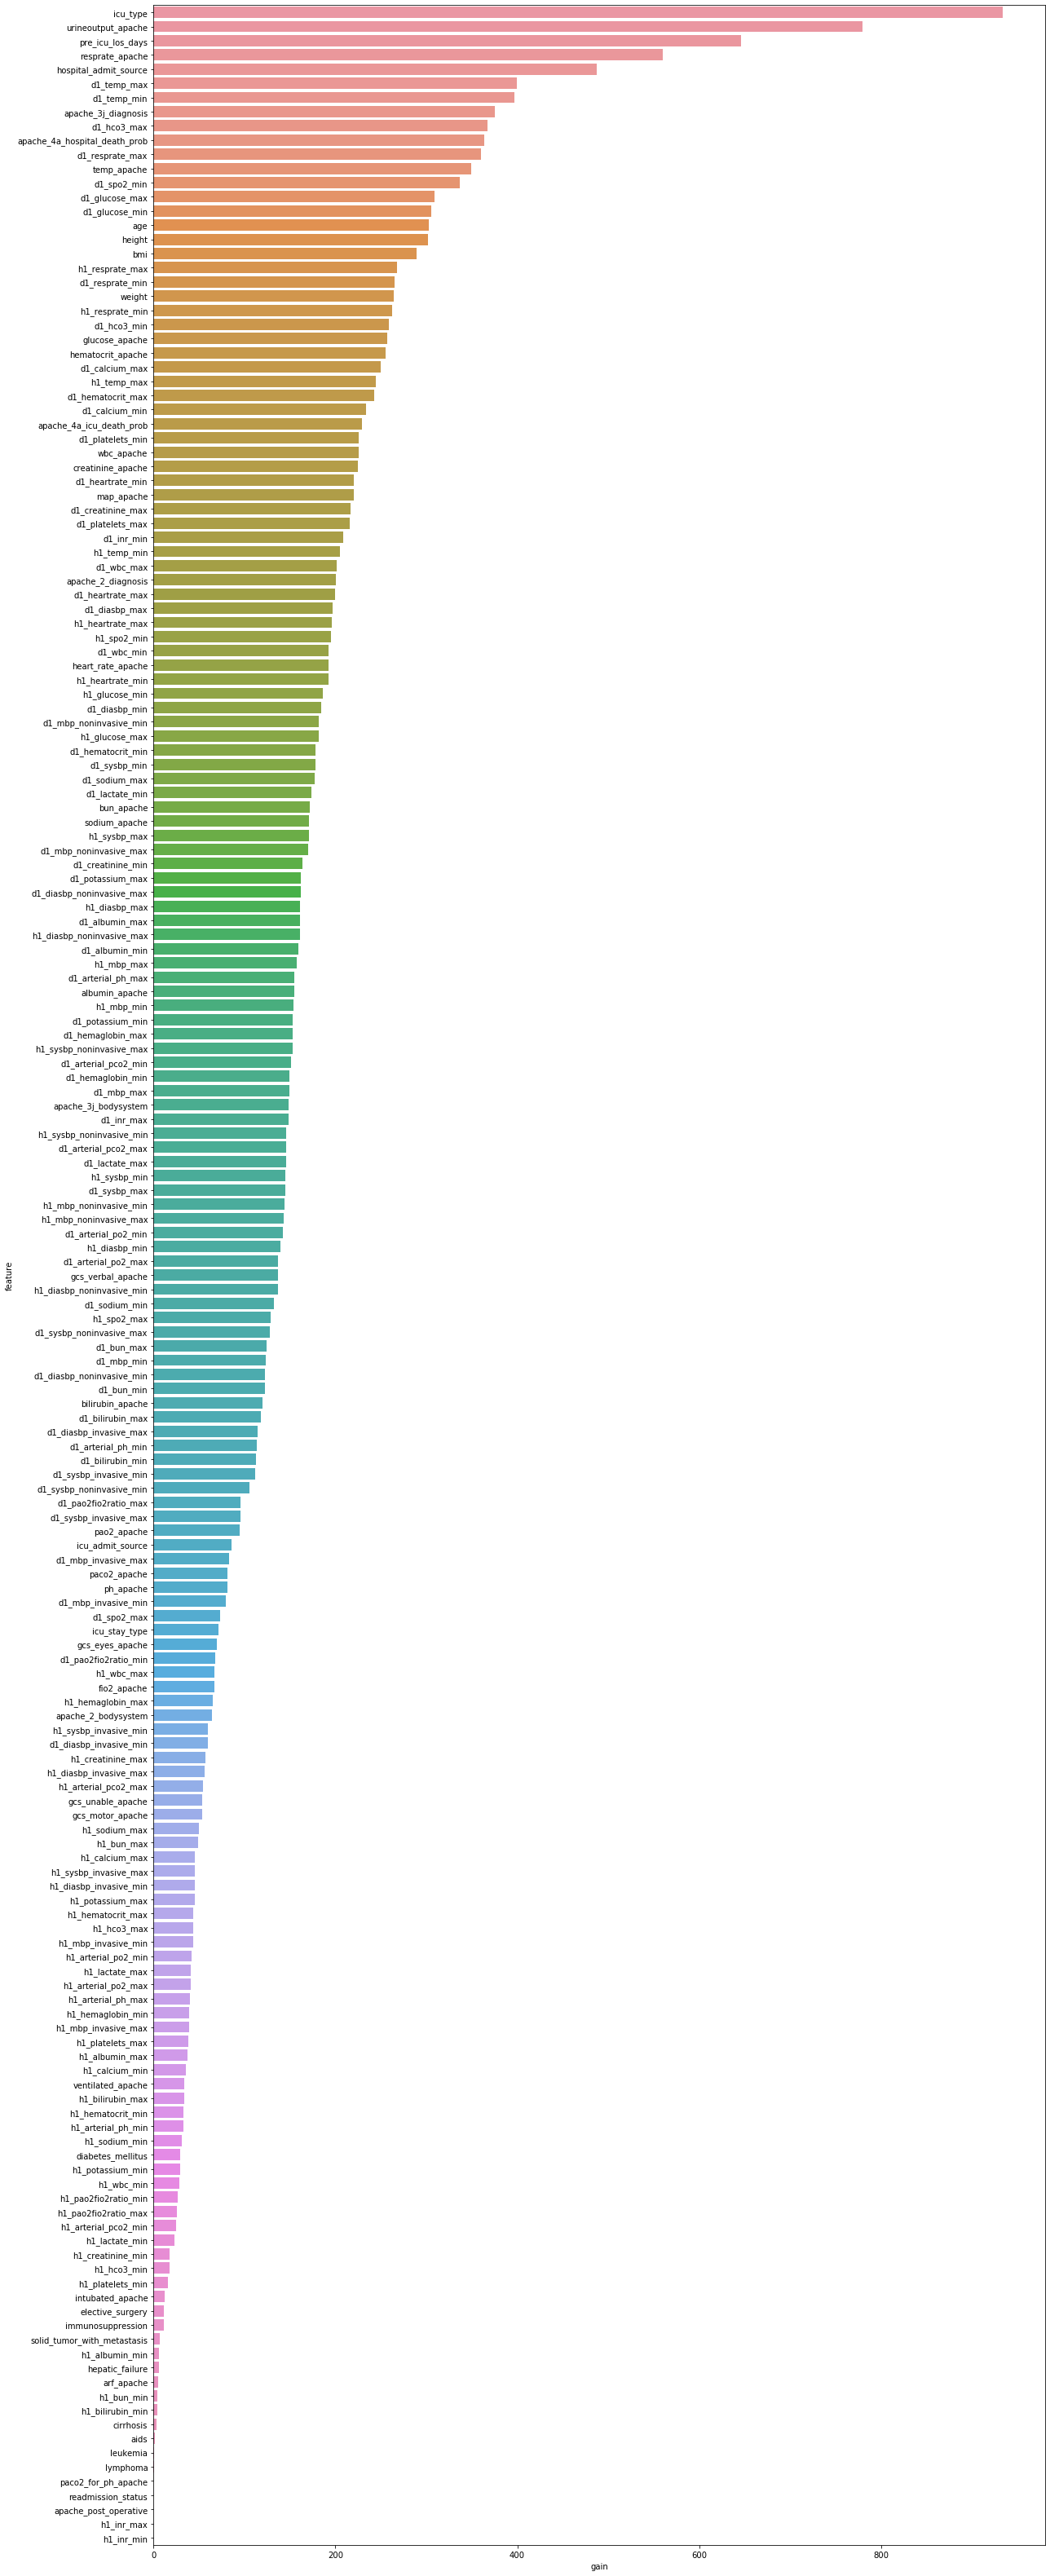

In [21]:
# I leave it to you to see what you can do with other features..
adversarial_features3 = adversarial_features3[['gain', 'feature']].groupby('feature').mean().reset_index()
adversarial_features3= adversarial_features3.sort_values('gain', ascending=False)

plot_importances(adversarial_features3)

icu_type 0 gain : 933.4


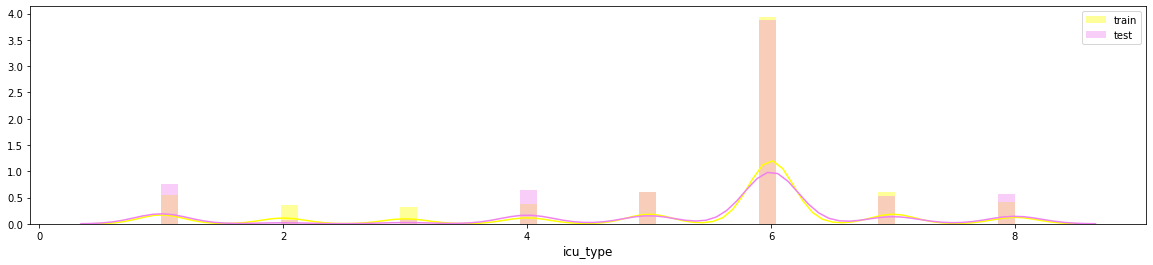

urineoutput_apache 1 gain : 779.8


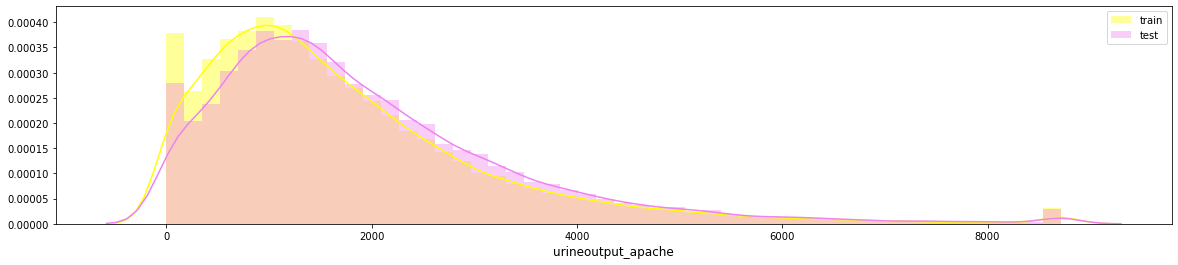

pre_icu_los_days 2 gain : 645.8


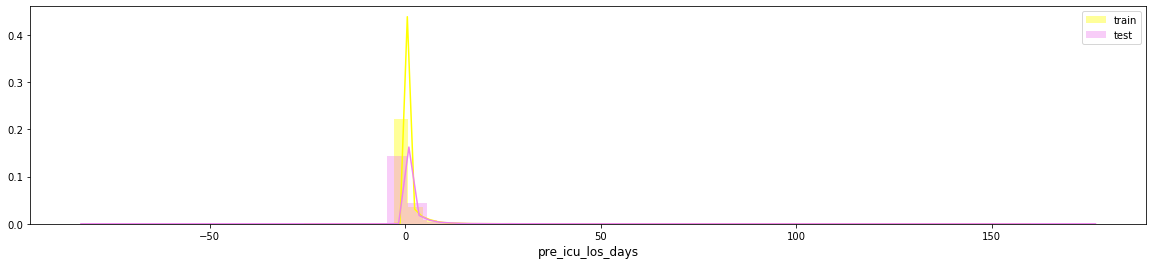

resprate_apache 3 gain : 560.0


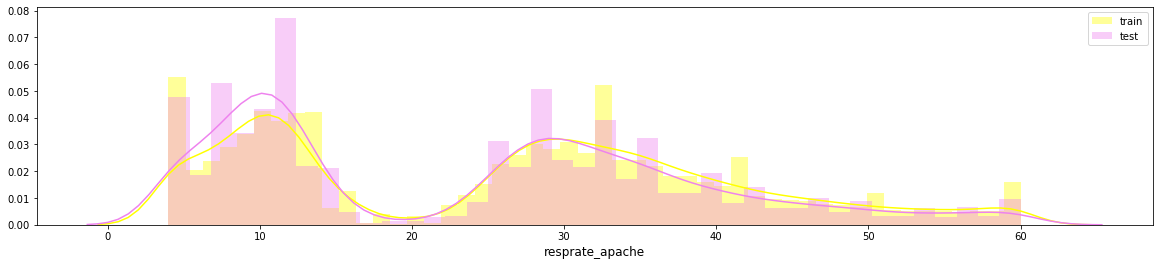

hospital_admit_source 4 gain : 487.8


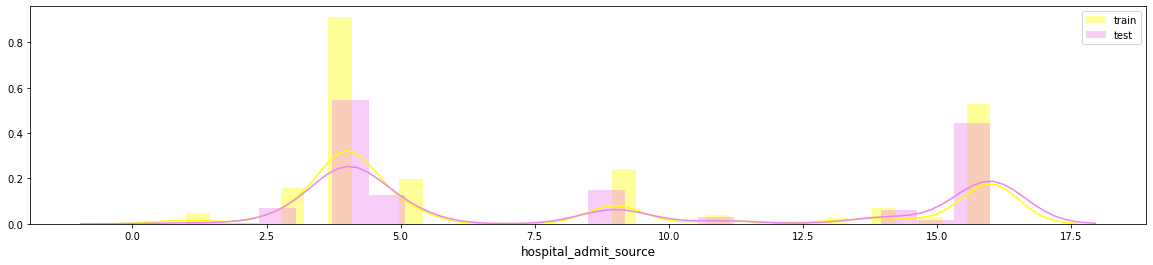

d1_temp_max 5 gain : 399.6


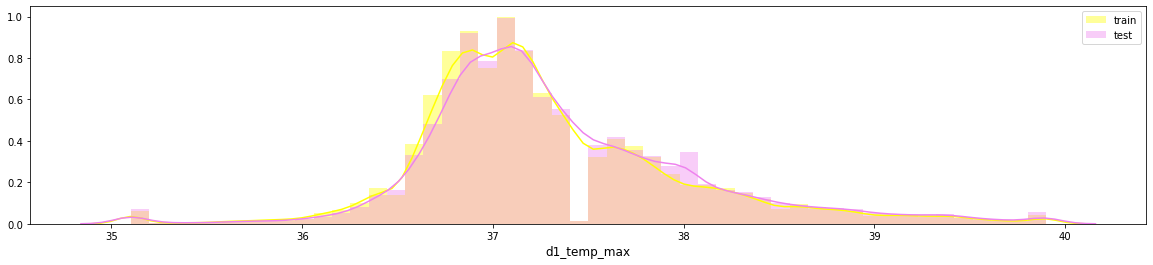

d1_temp_min 6 gain : 397.2


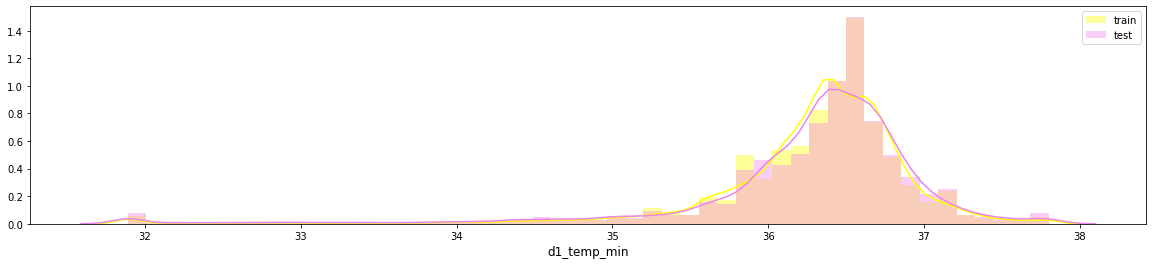

apache_3j_diagnosis 7 gain : 375.2


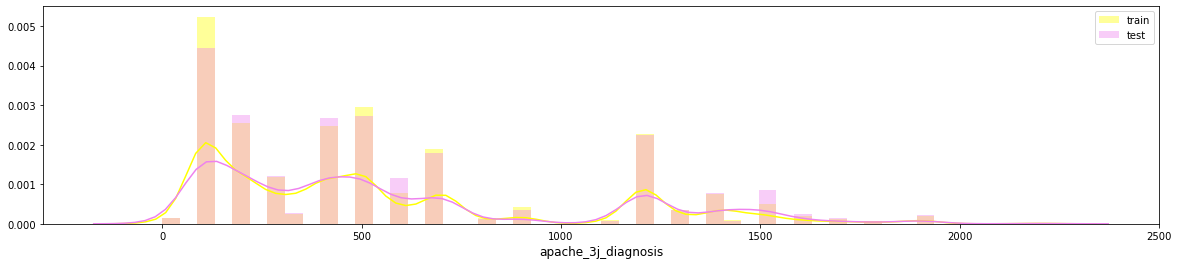

d1_hco3_max 8 gain : 367.0


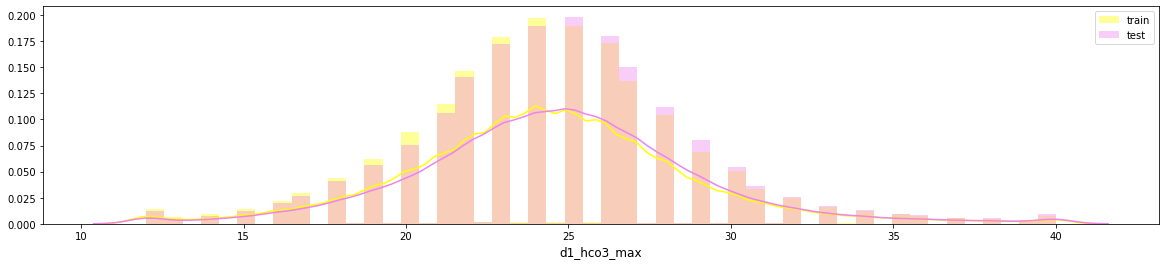

apache_4a_hospital_death_prob 9 gain : 363.6


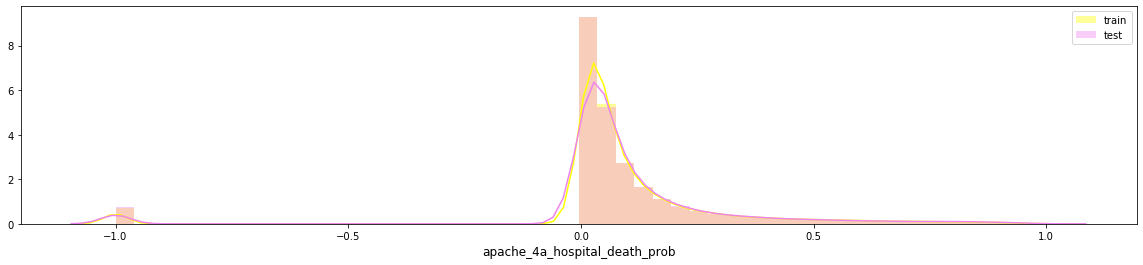

In [22]:
plot_differente_between_train_test(adversarial_features3)

In [23]:
# Lets remove hospital_id and icu_id

print('Difference between train and teste> -- hospital_id: ')
print(len(list(set(train['hospital_id']) - set(test['hospital_id']))))

print('\nDifference between train and teste> -- icu_id: ')
print(len(list(set(train['icu_id']) - set(test['icu_id']))))


# Drop features with zero importance
print('\nLength train features: {}'.format(len(features)))
for feat_to_remove in ['icu_id', 'hospital_id']:
    if feat_to_remove in categoricals_features:
        print('Removing from categoricals_features....{}'.format(feat_to_remove))
        categoricals_features.remove(feat_to_remove)
    if feat_to_remove in features:
        print('Removing from features....{}'.format(feat_to_remove))
        features.remove(feat_to_remove)
    
print('\nNew length train features: {}'.format(len(features)))

Difference between train and teste> -- hospital_id: 
138

Difference between train and teste> -- icu_id: 
229

Length train features: 181
Removing from features....icu_id
Removing from categoricals_features....hospital_id
Removing from features....hospital_id

New length train features: 179


# Model

In [24]:
# percentage of death , hopefully it s a bit unbalanced
train['hospital_death'].sum()/train['hospital_death'].count()

0.08630183289173836

# Hyper parameter tuning

In [25]:
# You want Bayesian Optimization?

#boll_BayesianOptimization = False
boll_BayesianOptimization = True

In [26]:
def LGB_Beyes(subsample_freq,
                    learning_rate,
                    feature_fraction,
                    max_depth,
                    lambda_l1,
                    lambda_l2,
                    scale_pos_weight):
    params={}
    params['subsample_freq']=subsample_freq
    params['learning_rate']=learning_rate
    params['feature_fraction']=feature_fraction
    params['lambda_l1']=lambda_l1
    params['lambda_l2']=lambda_l2
    params['max_depth']=max_depth
    params['scale_pos_weight']=scale_pos_weight
    
    lgb_model= Lgb_Model(train, test, features, categoricals=categoricals_features,ps=params)
    print('auc: ',lgb_model.score)
    return lgb_model.score

bounds_LGB = {
    'subsample_freq': (1, 10),
    'learning_rate': (0.005, 0.02),
    'feature_fraction': (0.5, 1),
    'lambda_l1': (0, 5),
    'lambda_l2': (0, 5),
    'max_depth': (13, 17),
    'scale_pos_weight': (1, 10),
}

# ACTIVATE it if you want to search for better parameter
if boll_BayesianOptimization: 
    LGB_BO = BayesianOptimization(LGB_Beyes, bounds_LGB, random_state=1029)
    import warnings
    init_points = 16
    n_iter = 16
    with warnings.catch_warnings():
        warnings.filterwarnings('ignore')    
        LGB_BO.maximize(init_points=init_points, n_iter=n_iter, acq='ucb', xi=0.0, alpha=1e-6)

|   iter    |  target   | featur... | lambda_l1 | lambda_l2 | learni... | max_depth | scale_... | subsam... |
-------------------------------------------------------------------------------------------------------------
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.909979	valid_1's auc: 0.893041
[200]	training's auc: 0.923307	valid_1's auc: 0.899997
[300]	training's auc: 0.933185	valid_1's auc: 0.902943
[400]	training's auc: 0.941547	valid_1's auc: 0.904688
[500]	training's auc: 0.948958	valid_1's auc: 0.905693
[600]	training's auc: 0.955244	valid_1's auc: 0.906392
[700]	training's auc: 0.960656	valid_1's auc: 0.906798
[800]	training's auc: 0.96552	valid_1's auc: 0.906988
[900]	training's auc: 0.969469	valid_1's auc: 0.907013
[1000]	training's auc: 0.973118	valid_1's auc: 0.906929
Early stopping, best iteration is:
[961]	training's auc: 0.971574	valid_1's auc: 0.907124
Partial score of fold 0 is: 0.9071238713237457
Training until validation score

[800]	training's auc: 0.955609	valid_1's auc: 0.906985
[900]	training's auc: 0.959799	valid_1's auc: 0.907525
[1000]	training's auc: 0.963531	valid_1's auc: 0.907553
[1100]	training's auc: 0.966758	valid_1's auc: 0.907555
[1200]	training's auc: 0.969815	valid_1's auc: 0.907786
[1300]	training's auc: 0.972575	valid_1's auc: 0.908116
[1400]	training's auc: 0.97505	valid_1's auc: 0.9081
Early stopping, best iteration is:
[1353]	training's auc: 0.973965	valid_1's auc: 0.908207
Partial score of fold 4 is: 0.9082065521257339
Our oof AUC score is:  0.9060776224846693
auc:  0.9060776224846693
|  2        |  0.9061   |  0.7977   |  1.678    |  2.208    |  0.01244  |  13.35    |  3.467    |  6.94     |
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.902942	valid_1's auc: 0.887795
[200]	training's auc: 0.910887	valid_1's auc: 0.892172
[300]	training's auc: 0.917555	valid_1's auc: 0.895677
[400]	training's auc: 0.923291	valid_1's auc: 0.898283
[500]	training's

Partial score of fold 0 is: 0.9066110765185587
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.909622	valid_1's auc: 0.888636
[200]	training's auc: 0.923127	valid_1's auc: 0.896762
[300]	training's auc: 0.932713	valid_1's auc: 0.900678
[400]	training's auc: 0.940539	valid_1's auc: 0.903088
[500]	training's auc: 0.947322	valid_1's auc: 0.904489
[600]	training's auc: 0.953298	valid_1's auc: 0.905339
[700]	training's auc: 0.95858	valid_1's auc: 0.905833
[800]	training's auc: 0.963205	valid_1's auc: 0.906185
[900]	training's auc: 0.967262	valid_1's auc: 0.906561
[1000]	training's auc: 0.970786	valid_1's auc: 0.906798
[1100]	training's auc: 0.973972	valid_1's auc: 0.906807
Early stopping, best iteration is:
[1062]	training's auc: 0.972832	valid_1's auc: 0.906897
Partial score of fold 1 is: 0.9068965153322066
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.91087	valid_1's auc: 0.884778
[200]	training's auc: 0.924112	

[1600]	training's auc: 0.970342	valid_1's auc: 0.90793
[1700]	training's auc: 0.972401	valid_1's auc: 0.907934
[1800]	training's auc: 0.974291	valid_1's auc: 0.907974
Early stopping, best iteration is:
[1767]	training's auc: 0.973657	valid_1's auc: 0.908039
Partial score of fold 4 is: 0.9080389650810192
Our oof AUC score is:  0.9053882153239876
auc:  0.9053882153239876
|  5        |  0.9054   |  0.9548   |  2.5      |  0.194    |  0.009008 |  13.47    |  3.556    |  5.414    |
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.91169	valid_1's auc: 0.893059
[200]	training's auc: 0.925443	valid_1's auc: 0.900131
[300]	training's auc: 0.935234	valid_1's auc: 0.903212
[400]	training's auc: 0.943868	valid_1's auc: 0.904795
[500]	training's auc: 0.951231	valid_1's auc: 0.90538
[600]	training's auc: 0.957468	valid_1's auc: 0.905724
[700]	training's auc: 0.963099	valid_1's auc: 0.905875
[800]	training's auc: 0.967691	valid_1's auc: 0.906
[900]	training's auc:

[1300]	training's auc: 0.962736	valid_1's auc: 0.904193
[1400]	training's auc: 0.965322	valid_1's auc: 0.904286
[1500]	training's auc: 0.967725	valid_1's auc: 0.904466
[1600]	training's auc: 0.969951	valid_1's auc: 0.904615
[1700]	training's auc: 0.971906	valid_1's auc: 0.904753
[1800]	training's auc: 0.973854	valid_1's auc: 0.90494
[1900]	training's auc: 0.975632	valid_1's auc: 0.904971
[2000]	training's auc: 0.977239	valid_1's auc: 0.905037
Early stopping, best iteration is:
[1990]	training's auc: 0.977091	valid_1's auc: 0.905044
Partial score of fold 3 is: 0.905044260733628
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.903799	valid_1's auc: 0.885631
[200]	training's auc: 0.913361	valid_1's auc: 0.892336
[300]	training's auc: 0.92117	valid_1's auc: 0.897735
[400]	training's auc: 0.92738	valid_1's auc: 0.901133
[500]	training's auc: 0.932726	valid_1's auc: 0.903042
[600]	training's auc: 0.937539	valid_1's auc: 0.904495
[700]	training's auc: 0.94

[600]	training's auc: 0.932075	valid_1's auc: 0.902255
[700]	training's auc: 0.936161	valid_1's auc: 0.903637
[800]	training's auc: 0.939924	valid_1's auc: 0.904736
[900]	training's auc: 0.943421	valid_1's auc: 0.90555
[1000]	training's auc: 0.946699	valid_1's auc: 0.90619
[1100]	training's auc: 0.949722	valid_1's auc: 0.906679
[1200]	training's auc: 0.952543	valid_1's auc: 0.907063
[1300]	training's auc: 0.955231	valid_1's auc: 0.907323
[1400]	training's auc: 0.957743	valid_1's auc: 0.907559
[1500]	training's auc: 0.960116	valid_1's auc: 0.907751
[1600]	training's auc: 0.962329	valid_1's auc: 0.907856
[1700]	training's auc: 0.964444	valid_1's auc: 0.907958
[1800]	training's auc: 0.966398	valid_1's auc: 0.908064
[1900]	training's auc: 0.968278	valid_1's auc: 0.908201
[2000]	training's auc: 0.970062	valid_1's auc: 0.908189
[2100]	training's auc: 0.97174	valid_1's auc: 0.908314
[2200]	training's auc: 0.9733	valid_1's auc: 0.908383
[2300]	training's auc: 0.974787	valid_1's auc: 0.908377
E

Early stopping, best iteration is:
[976]	training's auc: 0.965216	valid_1's auc: 0.904851
Partial score of fold 3 is: 0.9048510795361103
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.907228	valid_1's auc: 0.88824
[200]	training's auc: 0.919655	valid_1's auc: 0.89686
[300]	training's auc: 0.928644	valid_1's auc: 0.901286
[400]	training's auc: 0.935937	valid_1's auc: 0.90379
[500]	training's auc: 0.942289	valid_1's auc: 0.905136
[600]	training's auc: 0.948034	valid_1's auc: 0.905856
[700]	training's auc: 0.95336	valid_1's auc: 0.906459
[800]	training's auc: 0.957813	valid_1's auc: 0.907001
[900]	training's auc: 0.961915	valid_1's auc: 0.907258
[1000]	training's auc: 0.965498	valid_1's auc: 0.907505
[1100]	training's auc: 0.968779	valid_1's auc: 0.90758
[1200]	training's auc: 0.971726	valid_1's auc: 0.907624
Early stopping, best iteration is:
[1149]	training's auc: 0.970216	valid_1's auc: 0.907648
Partial score of fold 4 is: 0.907647702479998
Our oo

[600]	training's auc: 0.960962	valid_1's auc: 0.905879
[700]	training's auc: 0.966203	valid_1's auc: 0.906106
Early stopping, best iteration is:
[669]	training's auc: 0.9647	valid_1's auc: 0.906242
Partial score of fold 1 is: 0.9062421130236689
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.914828	valid_1's auc: 0.887701
[200]	training's auc: 0.928827	valid_1's auc: 0.895046
[300]	training's auc: 0.938992	valid_1's auc: 0.898102
[400]	training's auc: 0.947707	valid_1's auc: 0.899747
[500]	training's auc: 0.954955	valid_1's auc: 0.900502
[600]	training's auc: 0.960957	valid_1's auc: 0.900994
[700]	training's auc: 0.966383	valid_1's auc: 0.901127
[800]	training's auc: 0.970894	valid_1's auc: 0.901263
Early stopping, best iteration is:
[777]	training's auc: 0.969894	valid_1's auc: 0.901277
Partial score of fold 2 is: 0.9012773697866803
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.913464	valid_1's auc: 0.891652

[1200]	training's auc: 0.960426	valid_1's auc: 0.907392
[1300]	training's auc: 0.963187	valid_1's auc: 0.907499
[1400]	training's auc: 0.965718	valid_1's auc: 0.907453
[1500]	training's auc: 0.968081	valid_1's auc: 0.907686
[1600]	training's auc: 0.970305	valid_1's auc: 0.9077
Early stopping, best iteration is:
[1578]	training's auc: 0.969822	valid_1's auc: 0.907762
Partial score of fold 4 is: 0.9077616888100064
Our oof AUC score is:  0.9055948247354809
auc:  0.9055948247354809
|  13       |  0.9056   |  0.853    |  1.536    |  0.4828   |  0.008905 |  14.28    |  7.365    |  3.389    |
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.901987	valid_1's auc: 0.88803
[200]	training's auc: 0.913031	valid_1's auc: 0.894676
[300]	training's auc: 0.921665	valid_1's auc: 0.899464
[400]	training's auc: 0.92847	valid_1's auc: 0.90213
[500]	training's auc: 0.934446	valid_1's auc: 0.90367
[600]	training's auc: 0.940092	valid_1's auc: 0.904628
[700]	training's au

[300]	training's auc: 0.933611	valid_1's auc: 0.89747
[400]	training's auc: 0.941465	valid_1's auc: 0.899267
[500]	training's auc: 0.948285	valid_1's auc: 0.900204
[600]	training's auc: 0.953951	valid_1's auc: 0.901037
[700]	training's auc: 0.959374	valid_1's auc: 0.90144
[800]	training's auc: 0.963838	valid_1's auc: 0.901591
[900]	training's auc: 0.967891	valid_1's auc: 0.901727
[1000]	training's auc: 0.971566	valid_1's auc: 0.901697
Early stopping, best iteration is:
[944]	training's auc: 0.969619	valid_1's auc: 0.901882
Partial score of fold 2 is: 0.901881906051318
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.910798	valid_1's auc: 0.890728
[200]	training's auc: 0.923399	valid_1's auc: 0.896423
[300]	training's auc: 0.933179	valid_1's auc: 0.899929
[400]	training's auc: 0.941284	valid_1's auc: 0.901634
[500]	training's auc: 0.947894	valid_1's auc: 0.902727
[600]	training's auc: 0.953819	valid_1's auc: 0.903265
[700]	training's auc: 0.959026	va

[700]	training's auc: 0.926411	valid_1's auc: 0.899615
[800]	training's auc: 0.929498	valid_1's auc: 0.900676
[900]	training's auc: 0.932337	valid_1's auc: 0.901396
[1000]	training's auc: 0.935052	valid_1's auc: 0.902
[1100]	training's auc: 0.937618	valid_1's auc: 0.902574
[1200]	training's auc: 0.940183	valid_1's auc: 0.903058
[1300]	training's auc: 0.942576	valid_1's auc: 0.903366
[1400]	training's auc: 0.944833	valid_1's auc: 0.903681
[1500]	training's auc: 0.94703	valid_1's auc: 0.903997
[1600]	training's auc: 0.949097	valid_1's auc: 0.904245
[1700]	training's auc: 0.95109	valid_1's auc: 0.904483
[1800]	training's auc: 0.95291	valid_1's auc: 0.904686
[1900]	training's auc: 0.954747	valid_1's auc: 0.904871
[2000]	training's auc: 0.95649	valid_1's auc: 0.904973
[2100]	training's auc: 0.958131	valid_1's auc: 0.905054
[2200]	training's auc: 0.959693	valid_1's auc: 0.905162
[2300]	training's auc: 0.961238	valid_1's auc: 0.90524
[2400]	training's auc: 0.962706	valid_1's auc: 0.90531
[250

[800]	training's auc: 0.940684	valid_1's auc: 0.905925
[900]	training's auc: 0.944446	valid_1's auc: 0.906464
[1000]	training's auc: 0.947977	valid_1's auc: 0.906852
[1100]	training's auc: 0.951152	valid_1's auc: 0.907133
[1200]	training's auc: 0.954223	valid_1's auc: 0.907387
[1300]	training's auc: 0.957065	valid_1's auc: 0.907548
[1400]	training's auc: 0.959631	valid_1's auc: 0.90776
[1500]	training's auc: 0.962067	valid_1's auc: 0.907981
[1600]	training's auc: 0.964368	valid_1's auc: 0.907979
Early stopping, best iteration is:
[1547]	training's auc: 0.963097	valid_1's auc: 0.908021
Partial score of fold 0 is: 0.9080208570476589
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.896024	valid_1's auc: 0.881963
[200]	training's auc: 0.907063	valid_1's auc: 0.889511
[300]	training's auc: 0.915317	valid_1's auc: 0.894712
[400]	training's auc: 0.921887	valid_1's auc: 0.898471
[500]	training's auc: 0.927325	valid_1's auc: 0.900818
[600]	training's auc: 0.

[700]	training's auc: 0.943821	valid_1's auc: 0.901623
[800]	training's auc: 0.947934	valid_1's auc: 0.902084
[900]	training's auc: 0.951789	valid_1's auc: 0.902311
[1000]	training's auc: 0.955205	valid_1's auc: 0.902618
[1100]	training's auc: 0.958449	valid_1's auc: 0.902879
[1200]	training's auc: 0.961563	valid_1's auc: 0.903123
[1300]	training's auc: 0.964309	valid_1's auc: 0.903414
[1400]	training's auc: 0.966899	valid_1's auc: 0.903466
[1500]	training's auc: 0.969322	valid_1's auc: 0.903697
[1600]	training's auc: 0.971694	valid_1's auc: 0.903838
[1700]	training's auc: 0.973894	valid_1's auc: 0.904021
[1800]	training's auc: 0.975934	valid_1's auc: 0.904049
[1900]	training's auc: 0.97778	valid_1's auc: 0.904203
[2000]	training's auc: 0.979549	valid_1's auc: 0.904178
Early stopping, best iteration is:
[1939]	training's auc: 0.978464	valid_1's auc: 0.904249
Partial score of fold 2 is: 0.9042486774002414
Training until validation scores don't improve for 100 rounds
[100]	training's auc

[1600]	training's auc: 0.957291	valid_1's auc: 0.905634
[1700]	training's auc: 0.959305	valid_1's auc: 0.905799
[1800]	training's auc: 0.961268	valid_1's auc: 0.905821
[1900]	training's auc: 0.963229	valid_1's auc: 0.905819
[2000]	training's auc: 0.965058	valid_1's auc: 0.905921
[2100]	training's auc: 0.966774	valid_1's auc: 0.90596
[2200]	training's auc: 0.968388	valid_1's auc: 0.906063
[2300]	training's auc: 0.969889	valid_1's auc: 0.906076
[2400]	training's auc: 0.971326	valid_1's auc: 0.906046
Early stopping, best iteration is:
[2306]	training's auc: 0.969979	valid_1's auc: 0.906093
Partial score of fold 3 is: 0.9060930178962684
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.894754	valid_1's auc: 0.8824
[200]	training's auc: 0.903804	valid_1's auc: 0.88924
[300]	training's auc: 0.91099	valid_1's auc: 0.894331
[400]	training's auc: 0.917056	valid_1's auc: 0.898494
[500]	training's auc: 0.922155	valid_1's auc: 0.901195
[600]	training's auc: 0.92

[100]	training's auc: 0.899759	valid_1's auc: 0.888033
[200]	training's auc: 0.911127	valid_1's auc: 0.894875
[300]	training's auc: 0.920023	valid_1's auc: 0.8999
[400]	training's auc: 0.926915	valid_1's auc: 0.902599
[500]	training's auc: 0.932857	valid_1's auc: 0.904374
[600]	training's auc: 0.937984	valid_1's auc: 0.905573
[700]	training's auc: 0.942985	valid_1's auc: 0.906426
[800]	training's auc: 0.94745	valid_1's auc: 0.907121
[900]	training's auc: 0.951443	valid_1's auc: 0.907546
[1000]	training's auc: 0.955186	valid_1's auc: 0.907899
[1100]	training's auc: 0.958524	valid_1's auc: 0.90808
[1200]	training's auc: 0.961792	valid_1's auc: 0.908245
[1300]	training's auc: 0.96469	valid_1's auc: 0.908422
[1400]	training's auc: 0.967334	valid_1's auc: 0.908452
[1500]	training's auc: 0.969798	valid_1's auc: 0.908581
Early stopping, best iteration is:
[1496]	training's auc: 0.969715	valid_1's auc: 0.908597
Partial score of fold 0 is: 0.9085971999632129
Training until validation scores don

[500]	training's auc: 0.926585	valid_1's auc: 0.897832
[600]	training's auc: 0.931315	valid_1's auc: 0.899338
[700]	training's auc: 0.935525	valid_1's auc: 0.900363
[800]	training's auc: 0.939372	valid_1's auc: 0.901163
[900]	training's auc: 0.942931	valid_1's auc: 0.901778
[1000]	training's auc: 0.946204	valid_1's auc: 0.90224
[1100]	training's auc: 0.949235	valid_1's auc: 0.90264
[1200]	training's auc: 0.95207	valid_1's auc: 0.902895
[1300]	training's auc: 0.95471	valid_1's auc: 0.903153
[1400]	training's auc: 0.957215	valid_1's auc: 0.903323
[1500]	training's auc: 0.959522	valid_1's auc: 0.903506
[1600]	training's auc: 0.961753	valid_1's auc: 0.903594
[1700]	training's auc: 0.96395	valid_1's auc: 0.903778
[1800]	training's auc: 0.966019	valid_1's auc: 0.903897
[1900]	training's auc: 0.967907	valid_1's auc: 0.904093
[2000]	training's auc: 0.969719	valid_1's auc: 0.904133
Early stopping, best iteration is:
[1970]	training's auc: 0.969216	valid_1's auc: 0.904186
Partial score of fold 2

[1900]	training's auc: 0.956002	valid_1's auc: 0.903014
[2000]	training's auc: 0.957684	valid_1's auc: 0.903152
[2100]	training's auc: 0.959441	valid_1's auc: 0.903295
[2200]	training's auc: 0.961027	valid_1's auc: 0.903318
[2300]	training's auc: 0.962557	valid_1's auc: 0.903364
[2400]	training's auc: 0.964011	valid_1's auc: 0.903341
Early stopping, best iteration is:
[2315]	training's auc: 0.962802	valid_1's auc: 0.903375
Partial score of fold 2 is: 0.9033753243365895
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.892992	valid_1's auc: 0.885256
[200]	training's auc: 0.900999	valid_1's auc: 0.890097
[300]	training's auc: 0.907618	valid_1's auc: 0.893638
[400]	training's auc: 0.913393	valid_1's auc: 0.89651
[500]	training's auc: 0.918325	valid_1's auc: 0.898785
[600]	training's auc: 0.922434	valid_1's auc: 0.900277
[700]	training's auc: 0.926052	valid_1's auc: 0.901458
[800]	training's auc: 0.929391	valid_1's auc: 0.902405
[900]	training's auc: 0.9

[800]	training's auc: 0.957462	valid_1's auc: 0.907449
[900]	training's auc: 0.961566	valid_1's auc: 0.907626
[1000]	training's auc: 0.965346	valid_1's auc: 0.907799
[1100]	training's auc: 0.968549	valid_1's auc: 0.907864
[1200]	training's auc: 0.971686	valid_1's auc: 0.908057
[1300]	training's auc: 0.974355	valid_1's auc: 0.908104
[1400]	training's auc: 0.976873	valid_1's auc: 0.908225
[1500]	training's auc: 0.979356	valid_1's auc: 0.908099
Early stopping, best iteration is:
[1440]	training's auc: 0.97792	valid_1's auc: 0.908252
Partial score of fold 0 is: 0.9082515299037959
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.903693	valid_1's auc: 0.88734
[200]	training's auc: 0.916941	valid_1's auc: 0.895076
[300]	training's auc: 0.926342	valid_1's auc: 0.899487
[400]	training's auc: 0.93409	valid_1's auc: 0.90212
[500]	training's auc: 0.94126	valid_1's auc: 0.903683
[600]	training's auc: 0.947556	valid_1's auc: 0.904901
[700]	training's auc: 0.95280

Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.903991	valid_1's auc: 0.890161
[200]	training's auc: 0.917343	valid_1's auc: 0.898566
[300]	training's auc: 0.926563	valid_1's auc: 0.902478
[400]	training's auc: 0.934134	valid_1's auc: 0.904725
[500]	training's auc: 0.94099	valid_1's auc: 0.906178
[600]	training's auc: 0.946838	valid_1's auc: 0.90677
[700]	training's auc: 0.951991	valid_1's auc: 0.907227
[800]	training's auc: 0.956611	valid_1's auc: 0.907742
[900]	training's auc: 0.960372	valid_1's auc: 0.908043
[1000]	training's auc: 0.964272	valid_1's auc: 0.908089
[1100]	training's auc: 0.967575	valid_1's auc: 0.908363
[1200]	training's auc: 0.97083	valid_1's auc: 0.908498
[1300]	training's auc: 0.97357	valid_1's auc: 0.908455
Early stopping, best iteration is:
[1239]	training's auc: 0.971886	valid_1's auc: 0.90859
Partial score of fold 0 is: 0.9085900385510126
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.

[600]	training's auc: 0.94572	valid_1's auc: 0.907156
[700]	training's auc: 0.950952	valid_1's auc: 0.907712
[800]	training's auc: 0.955636	valid_1's auc: 0.908033
[900]	training's auc: 0.959662	valid_1's auc: 0.908282
[1000]	training's auc: 0.963679	valid_1's auc: 0.90846
[1100]	training's auc: 0.967012	valid_1's auc: 0.908684
[1200]	training's auc: 0.970367	valid_1's auc: 0.908808
[1300]	training's auc: 0.973143	valid_1's auc: 0.908742
Early stopping, best iteration is:
[1206]	training's auc: 0.970526	valid_1's auc: 0.908844
Partial score of fold 4 is: 0.9088442197000568
Our oof AUC score is:  0.9068568675594261
auc:  0.9068568675594261
|  29       |  0.9069   |  0.6403   |  0.3946   |  4.887    |  0.01584  |  16.7     |  1.12     |  1.153    |
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.888106	valid_1's auc: 0.877448
[200]	training's auc: 0.894947	valid_1's auc: 0.883078
[300]	training's auc: 0.900622	valid_1's auc: 0.886934
[400]	training's

[100]	training's auc: 0.888989	valid_1's auc: 0.883123
[200]	training's auc: 0.894905	valid_1's auc: 0.886813
[300]	training's auc: 0.900834	valid_1's auc: 0.889357
[400]	training's auc: 0.905697	valid_1's auc: 0.892274
[500]	training's auc: 0.909925	valid_1's auc: 0.894531
[600]	training's auc: 0.913895	valid_1's auc: 0.896529
[700]	training's auc: 0.917384	valid_1's auc: 0.898105
[800]	training's auc: 0.920448	valid_1's auc: 0.899269
[900]	training's auc: 0.923244	valid_1's auc: 0.900239
[1000]	training's auc: 0.925843	valid_1's auc: 0.901086
[1100]	training's auc: 0.928203	valid_1's auc: 0.901744
[1200]	training's auc: 0.930521	valid_1's auc: 0.902259
[1300]	training's auc: 0.93276	valid_1's auc: 0.902703
[1400]	training's auc: 0.934898	valid_1's auc: 0.903191
[1500]	training's auc: 0.936948	valid_1's auc: 0.903503
[1600]	training's auc: 0.938891	valid_1's auc: 0.903755
[1700]	training's auc: 0.940748	valid_1's auc: 0.904047
[1800]	training's auc: 0.942579	valid_1's auc: 0.904272
[1

[1200]	training's auc: 0.987428	valid_1's auc: 0.908419
Early stopping, best iteration is:
[1143]	training's auc: 0.985967	valid_1's auc: 0.90853
Partial score of fold 4 is: 0.9085298903330132
Our oof AUC score is:  0.9061358182629627
auc:  0.9061358182629627
|  31       |  0.9061   |  0.6976   |  0.2635   |  0.1762   |  0.01946  |  16.94    |  1.392    |  1.013    |
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.902744	valid_1's auc: 0.888646
[200]	training's auc: 0.915535	valid_1's auc: 0.897368
[300]	training's auc: 0.924676	valid_1's auc: 0.901682
[400]	training's auc: 0.932003	valid_1's auc: 0.904039
[500]	training's auc: 0.938663	valid_1's auc: 0.905414
[600]	training's auc: 0.944387	valid_1's auc: 0.906436
[700]	training's auc: 0.949532	valid_1's auc: 0.907079
[800]	training's auc: 0.954038	valid_1's auc: 0.90744
[900]	training's auc: 0.957884	valid_1's auc: 0.907584
[1000]	training's auc: 0.961542	valid_1's auc: 0.907882
[1100]	training's 

In [27]:
LGB_BO.max['params']

{'feature_fraction': 0.5348508368206359,
 'lambda_l1': 0.0009370993396629057,
 'lambda_l2': 4.743745312344983,
 'learning_rate': 0.012891827059322746,
 'max_depth': 15.784155449197529,
 'scale_pos_weight': 1.0325760631926175,
 'subsample_freq': 1.0744384574974872}

In [28]:
# params = {'feature_fraction': 0.9,
#  'lambda_l1': 1,
#  'lambda_l2': 1,
#  'learning_rate': 0.1,
#  'max_depth': 13,
#  'subsample_freq': 1,
#  'scale_pos_weight':1}

# Best Hyperparams from Bayesian Optimization in notebook lgb-v2
params = {'feature_fraction': 0.524207414205945,
 'lambda_l1': 4.171808735757517,
 'lambda_l2': 4.6435328298317256,
 'learning_rate': 0.007897539397989824,
 'max_depth': 16.62053004755999,
 'scale_pos_weight': 1.2199266532301127,
 'subsample_freq': 1.0276518730971627}


# Best Hyperparams from Bayesian Optimization in notebook lgb-v3
params = {'feature_fraction': 0.524207414205945,
 'lambda_l1': 4.171808735757517,
 'lambda_l2': 4.6435328298317256,
 'learning_rate': 0.007897539397989824,
 'max_depth': 16.62053004755999,
 'scale_pos_weight': 1.2199266532301127,
 'subsample_freq': 1.0276518730971627}


In [29]:
if boll_BayesianOptimization: # ACTIVATE it if you want to search/use for better parameter
    lgb_model = Lgb_Model(train,test, features, categoricals=categoricals_features, ps= LGB_BO.max['params'])
else :
    lgb_model = Lgb_Model(train,test, features, categoricals=categoricals_features, ps=params)

Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.899759	valid_1's auc: 0.888033
[200]	training's auc: 0.911127	valid_1's auc: 0.894875
[300]	training's auc: 0.920023	valid_1's auc: 0.8999
[400]	training's auc: 0.926915	valid_1's auc: 0.902599
[500]	training's auc: 0.932857	valid_1's auc: 0.904374
[600]	training's auc: 0.937984	valid_1's auc: 0.905573
[700]	training's auc: 0.942985	valid_1's auc: 0.906426
[800]	training's auc: 0.94745	valid_1's auc: 0.907121
[900]	training's auc: 0.951443	valid_1's auc: 0.907546
[1000]	training's auc: 0.955186	valid_1's auc: 0.907899
[1100]	training's auc: 0.958524	valid_1's auc: 0.90808
[1200]	training's auc: 0.961792	valid_1's auc: 0.908245
[1300]	training's auc: 0.96469	valid_1's auc: 0.908422
[1400]	training's auc: 0.967334	valid_1's auc: 0.908452
[1500]	training's auc: 0.969798	valid_1's auc: 0.908581
Early stopping, best iteration is:
[1496]	training's auc: 0.969715	valid_1's auc: 0.908597
Partial score of fold

Feature Importance from the lightgbm model (gain)

In [30]:
imp_df = pd.DataFrame()
imp_df['feature'] = features
imp_df['gain']  = lgb_model.model.feature_importance(importance_type='gain')
imp_df['split'] = lgb_model.model.feature_importance(importance_type='split')

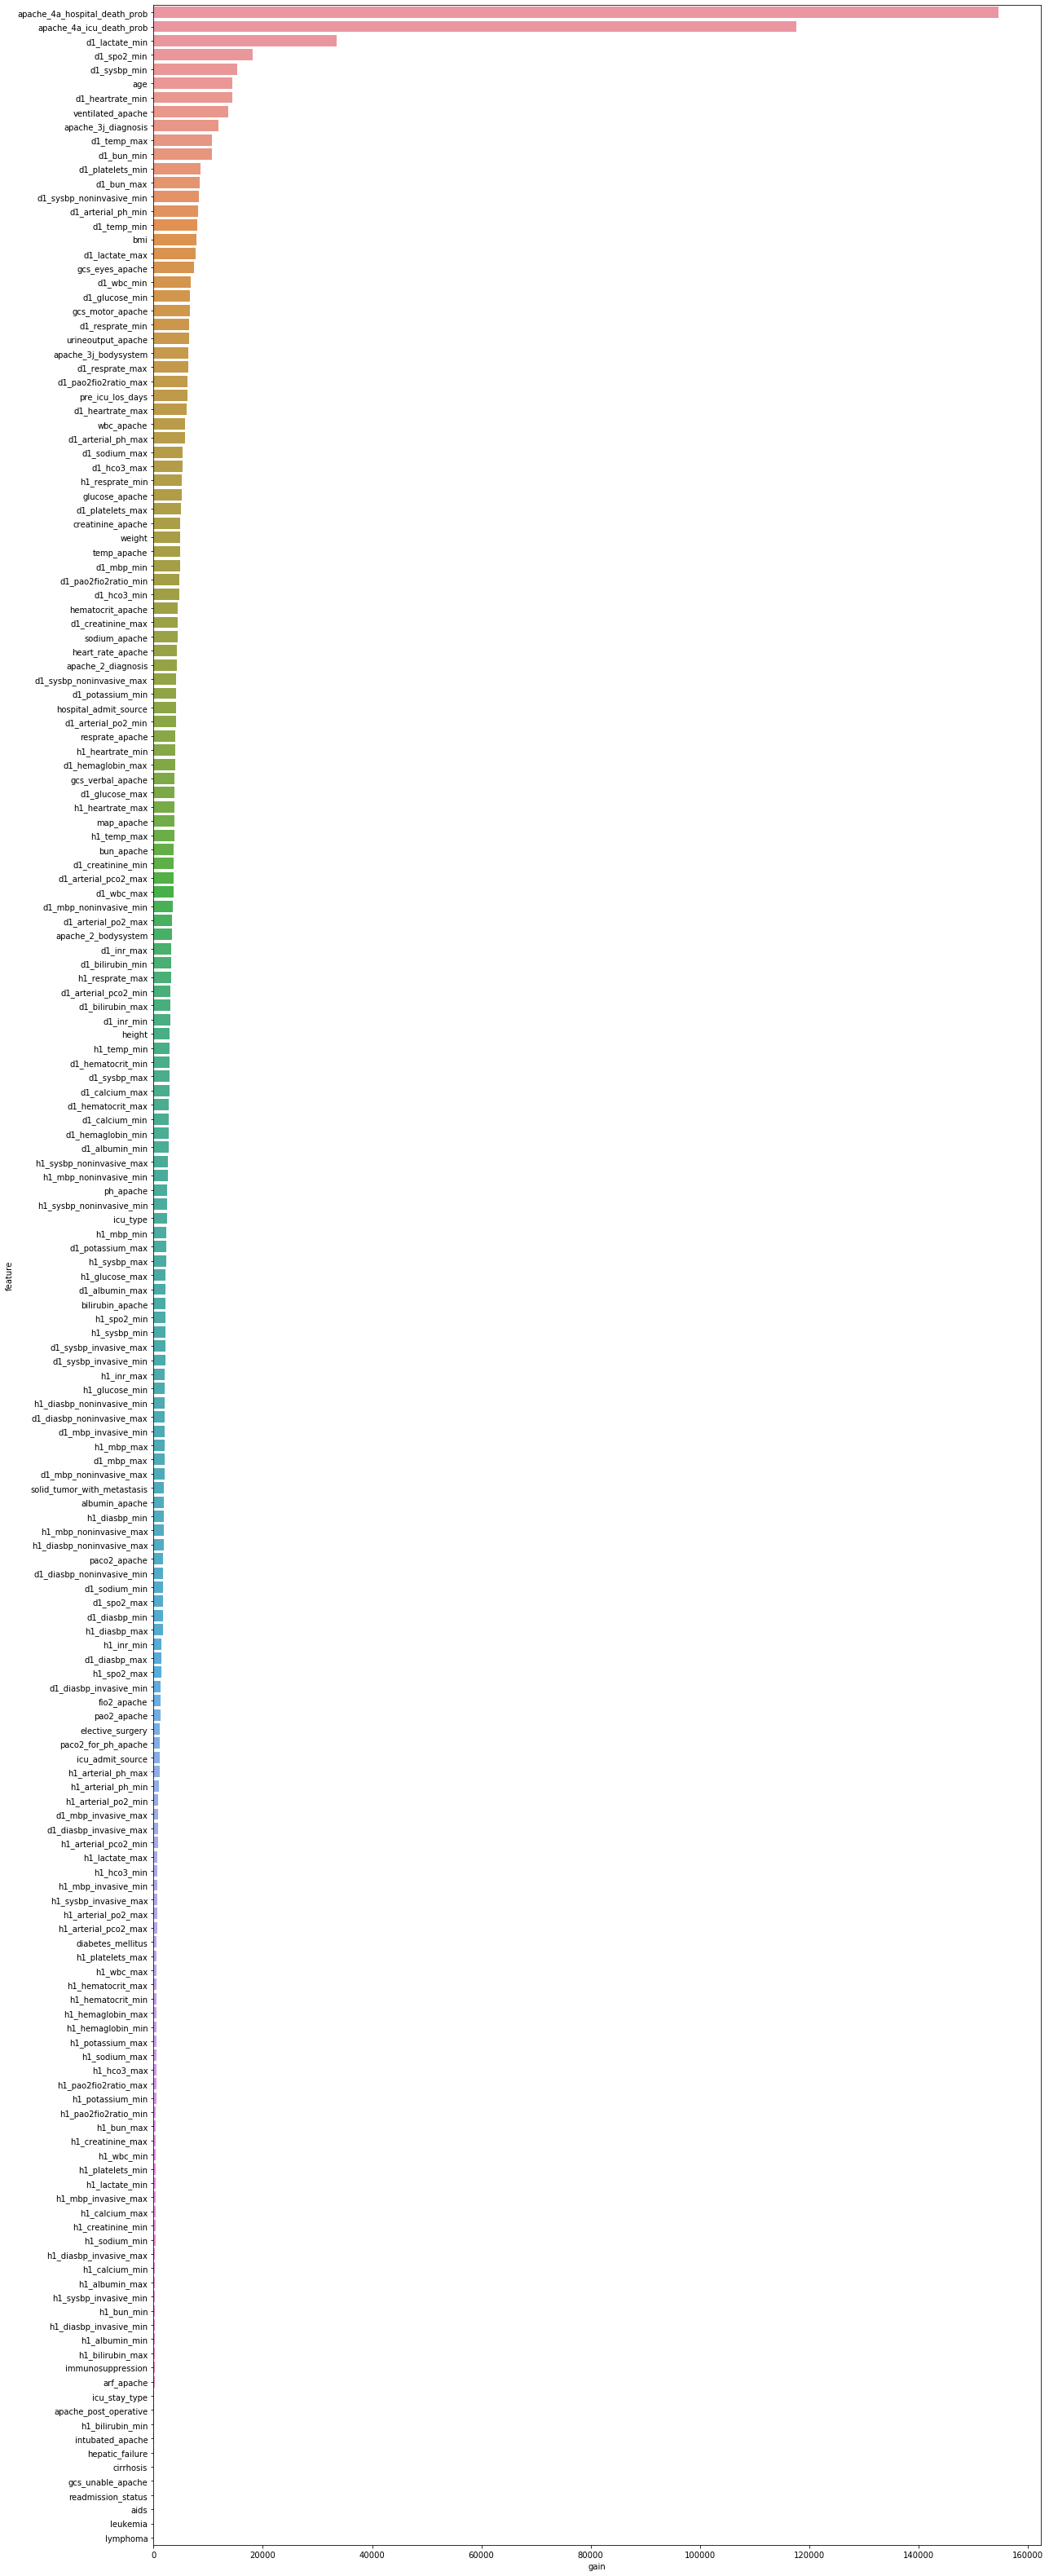

In [31]:
plot_importances(imp_df)

# Feature Importance by permutation importance algo

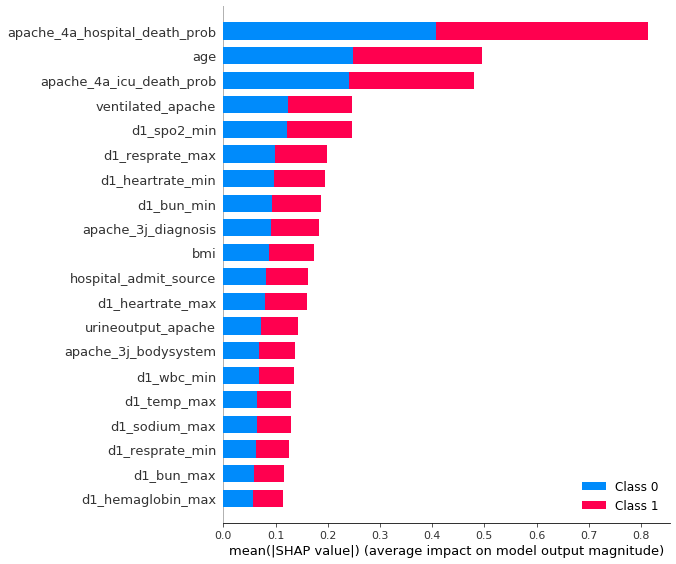

In [32]:
import shap
explainer   =  shap.TreeExplainer(lgb_model.model)
shap_values = explainer.shap_values(train[features].iloc[:1000,:])
shap.summary_plot(shap_values, train[features].iloc[:1000,:])

# Some univariate plot of the best feature

## Feature Selection

In [33]:
# Find the features with zero importance

imp_df_sorted = imp_df.sort_values('gain', ascending = False)

zero_features = list(imp_df_sorted[imp_df_sorted['gain'] == 0.0]['feature'])

print('There are %d features with 0.0 importance' % len(zero_features))
imp_df_sorted.tail()

# Drop features with zero importance
print('\nLength train features: {}'.format(len(features)))
for feat_to_remove in zero_features:
    print('Removing....{}'.format(feat_to_remove))
    features.remove(feat_to_remove)

print('\nNew length train features: {}'.format(len(features)))    

There are 4 features with 0.0 importance

Length train features: 179
Removing....readmission_status
Removing....aids
Removing....leukemia
Removing....lymphoma

New length train features: 175


## New Model with Feature Selection and Parametes Tuning

In [34]:
# Hyper parameter tuning

boll_BayesianOptimization = True

In [35]:
# ACTIVATE it if you want to search for better parameter
if boll_BayesianOptimization: 
    LGB_BO_v2 = BayesianOptimization(LGB_Beyes, bounds_LGB, random_state=1029)
    import warnings
    init_points = 16
    n_iter = 16
    with warnings.catch_warnings():
        warnings.filterwarnings('ignore')    
        LGB_BO_v2.maximize(init_points=init_points, n_iter=n_iter, acq='ucb', xi=0.0, alpha=1e-6)

|   iter    |  target   | featur... | lambda_l1 | lambda_l2 | learni... | max_depth | scale_... | subsam... |
-------------------------------------------------------------------------------------------------------------
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.91049	valid_1's auc: 0.893793
[200]	training's auc: 0.9233	valid_1's auc: 0.900102
[300]	training's auc: 0.933042	valid_1's auc: 0.903301
[400]	training's auc: 0.941353	valid_1's auc: 0.905201
[500]	training's auc: 0.94884	valid_1's auc: 0.906188
[600]	training's auc: 0.954945	valid_1's auc: 0.906518
[700]	training's auc: 0.960322	valid_1's auc: 0.90684
[800]	training's auc: 0.965193	valid_1's auc: 0.907115
[900]	training's auc: 0.969141	valid_1's auc: 0.906873
Early stopping, best iteration is:
[804]	training's auc: 0.965334	valid_1's auc: 0.907123
Partial score of fold 0 is: 0.9071227782660939
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.91079

[700]	training's auc: 0.950889	valid_1's auc: 0.906513
[800]	training's auc: 0.955663	valid_1's auc: 0.906929
[900]	training's auc: 0.959819	valid_1's auc: 0.907412
[1000]	training's auc: 0.963406	valid_1's auc: 0.907611
[1100]	training's auc: 0.966642	valid_1's auc: 0.907467
Early stopping, best iteration is:
[1014]	training's auc: 0.963854	valid_1's auc: 0.90768
Partial score of fold 4 is: 0.9076798553700434
Our oof AUC score is:  0.9059216567736055
auc:  0.9059216567736055
|  2        |  0.9059   |  0.7977   |  1.678    |  2.208    |  0.01244  |  13.35    |  3.467    |  6.94     |
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.903469	valid_1's auc: 0.888712
[200]	training's auc: 0.910974	valid_1's auc: 0.892489
[300]	training's auc: 0.917471	valid_1's auc: 0.895706
[400]	training's auc: 0.923185	valid_1's auc: 0.898268
[500]	training's auc: 0.928175	valid_1's auc: 0.900131
[600]	training's auc: 0.932619	valid_1's auc: 0.901623
[700]	training's 

[600]	training's auc: 0.953198	valid_1's auc: 0.904995
[700]	training's auc: 0.95842	valid_1's auc: 0.905528
[800]	training's auc: 0.963024	valid_1's auc: 0.905855
[900]	training's auc: 0.966986	valid_1's auc: 0.906084
Early stopping, best iteration is:
[873]	training's auc: 0.965946	valid_1's auc: 0.906147
Partial score of fold 0 is: 0.9061474316160518
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.909838	valid_1's auc: 0.888835
[200]	training's auc: 0.923332	valid_1's auc: 0.896869
[300]	training's auc: 0.932917	valid_1's auc: 0.900868
[400]	training's auc: 0.940804	valid_1's auc: 0.903229
[500]	training's auc: 0.947817	valid_1's auc: 0.904532
[600]	training's auc: 0.953652	valid_1's auc: 0.905392
[700]	training's auc: 0.95887	valid_1's auc: 0.905719
[800]	training's auc: 0.963457	valid_1's auc: 0.905893
[900]	training's auc: 0.967446	valid_1's auc: 0.906024
[1000]	training's auc: 0.971037	valid_1's auc: 0.906232
[1100]	training's auc: 0.974225	

Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.902525	valid_1's auc: 0.885559
[200]	training's auc: 0.912808	valid_1's auc: 0.892403
[300]	training's auc: 0.920708	valid_1's auc: 0.898108
[400]	training's auc: 0.927055	valid_1's auc: 0.900958
[500]	training's auc: 0.932562	valid_1's auc: 0.902879
[600]	training's auc: 0.937531	valid_1's auc: 0.904161
[700]	training's auc: 0.942131	valid_1's auc: 0.905202
[800]	training's auc: 0.946339	valid_1's auc: 0.906093
[900]	training's auc: 0.950304	valid_1's auc: 0.906509
[1000]	training's auc: 0.953862	valid_1's auc: 0.907005
[1100]	training's auc: 0.957287	valid_1's auc: 0.907047
[1200]	training's auc: 0.960274	valid_1's auc: 0.907245
[1300]	training's auc: 0.963084	valid_1's auc: 0.907359
[1400]	training's auc: 0.965713	valid_1's auc: 0.907501
[1500]	training's auc: 0.968149	valid_1's auc: 0.907635
[1600]	training's auc: 0.97043	valid_1's auc: 0.907858
[1700]	training's auc: 0.972485	valid_1's auc: 0.908

[900]	training's auc: 0.950337	valid_1's auc: 0.900567
[1000]	training's auc: 0.953752	valid_1's auc: 0.900975
[1100]	training's auc: 0.956858	valid_1's auc: 0.90137
[1200]	training's auc: 0.959781	valid_1's auc: 0.901667
[1300]	training's auc: 0.962503	valid_1's auc: 0.901859
[1400]	training's auc: 0.96505	valid_1's auc: 0.901938
[1500]	training's auc: 0.967392	valid_1's auc: 0.902074
[1600]	training's auc: 0.969585	valid_1's auc: 0.902087
Early stopping, best iteration is:
[1522]	training's auc: 0.967869	valid_1's auc: 0.902131
Partial score of fold 2 is: 0.9021307462794579
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.904145	valid_1's auc: 0.887642
[200]	training's auc: 0.913534	valid_1's auc: 0.892374
[300]	training's auc: 0.921305	valid_1's auc: 0.896055
[400]	training's auc: 0.927631	valid_1's auc: 0.898772
[500]	training's auc: 0.932997	valid_1's auc: 0.900493
[600]	training's auc: 0.937843	valid_1's auc: 0.90184
[700]	training's auc: 0.94

Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.901366	valid_1's auc: 0.883372
[200]	training's auc: 0.90951	valid_1's auc: 0.888741
[300]	training's auc: 0.916374	valid_1's auc: 0.893591
[400]	training's auc: 0.922289	valid_1's auc: 0.897517
[500]	training's auc: 0.927446	valid_1's auc: 0.900329
[600]	training's auc: 0.931929	valid_1's auc: 0.90217
[700]	training's auc: 0.936027	valid_1's auc: 0.903628
[800]	training's auc: 0.939805	valid_1's auc: 0.904701
[900]	training's auc: 0.943345	valid_1's auc: 0.905512
[1000]	training's auc: 0.946587	valid_1's auc: 0.906186
[1100]	training's auc: 0.949631	valid_1's auc: 0.906561
[1200]	training's auc: 0.952527	valid_1's auc: 0.906888
[1300]	training's auc: 0.955207	valid_1's auc: 0.907176
[1400]	training's auc: 0.957714	valid_1's auc: 0.90737
[1500]	training's auc: 0.960067	valid_1's auc: 0.907599
[1600]	training's auc: 0.962301	valid_1's auc: 0.907699
[1700]	training's auc: 0.964389	valid_1's auc: 0.90788

[400]	training's auc: 0.936557	valid_1's auc: 0.901403
[500]	training's auc: 0.943013	valid_1's auc: 0.902726
[600]	training's auc: 0.948761	valid_1's auc: 0.903753
[700]	training's auc: 0.953813	valid_1's auc: 0.904335
[800]	training's auc: 0.958305	valid_1's auc: 0.904638
[900]	training's auc: 0.962348	valid_1's auc: 0.905024
[1000]	training's auc: 0.965816	valid_1's auc: 0.905076
[1100]	training's auc: 0.969091	valid_1's auc: 0.905171
[1200]	training's auc: 0.972213	valid_1's auc: 0.905147
Early stopping, best iteration is:
[1107]	training's auc: 0.969291	valid_1's auc: 0.905193
Partial score of fold 3 is: 0.9051928500566746
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.907108	valid_1's auc: 0.887148
[200]	training's auc: 0.919439	valid_1's auc: 0.896142
[300]	training's auc: 0.928537	valid_1's auc: 0.900503
[400]	training's auc: 0.935887	valid_1's auc: 0.903171
[500]	training's auc: 0.942439	valid_1's auc: 0.904459
[600]	training's auc: 0.948

[700]	training's auc: 0.965888	valid_1's auc: 0.905545
[800]	training's auc: 0.970478	valid_1's auc: 0.905685
[900]	training's auc: 0.97448	valid_1's auc: 0.905599
Early stopping, best iteration is:
[801]	training's auc: 0.97053	valid_1's auc: 0.90569
Partial score of fold 0 is: 0.90568993045138
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.913632	valid_1's auc: 0.892002
[200]	training's auc: 0.92804	valid_1's auc: 0.899538
[300]	training's auc: 0.938421	valid_1's auc: 0.902495
[400]	training's auc: 0.947147	valid_1's auc: 0.904311
[500]	training's auc: 0.954594	valid_1's auc: 0.905299
[600]	training's auc: 0.960833	valid_1's auc: 0.905691
[700]	training's auc: 0.966131	valid_1's auc: 0.905892
[800]	training's auc: 0.970812	valid_1's auc: 0.906158
[900]	training's auc: 0.974861	valid_1's auc: 0.906194
Early stopping, best iteration is:
[879]	training's auc: 0.974133	valid_1's auc: 0.906312
Partial score of fold 1 is: 0.9063123325548754
Training u

[1100]	training's auc: 0.957107	valid_1's auc: 0.906593
[1200]	training's auc: 0.960104	valid_1's auc: 0.90677
[1300]	training's auc: 0.962935	valid_1's auc: 0.906958
[1400]	training's auc: 0.965552	valid_1's auc: 0.906992
[1500]	training's auc: 0.967997	valid_1's auc: 0.907004
[1600]	training's auc: 0.970211	valid_1's auc: 0.907045
[1700]	training's auc: 0.972358	valid_1's auc: 0.907128
[1800]	training's auc: 0.974351	valid_1's auc: 0.907179
[1900]	training's auc: 0.976131	valid_1's auc: 0.907254
Early stopping, best iteration is:
[1863]	training's auc: 0.975499	valid_1's auc: 0.907269
Partial score of fold 4 is: 0.9072685396183726
Our oof AUC score is:  0.905309946005131
auc:  0.905309946005131
|  13       |  0.9053   |  0.853    |  1.536    |  0.4828   |  0.008905 |  14.28    |  7.365    |  3.389    |
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.902352	valid_1's auc: 0.888545
[200]	training's auc: 0.913224	valid_1's auc: 0.894723
[300]	traini

[900]	training's auc: 0.96788	valid_1's auc: 0.901846
[1000]	training's auc: 0.971538	valid_1's auc: 0.902036
[1100]	training's auc: 0.974689	valid_1's auc: 0.901993
Early stopping, best iteration is:
[1045]	training's auc: 0.973009	valid_1's auc: 0.902181
Partial score of fold 2 is: 0.9021807253982876
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.910601	valid_1's auc: 0.889781
[200]	training's auc: 0.92341	valid_1's auc: 0.896147
[300]	training's auc: 0.933142	valid_1's auc: 0.899818
[400]	training's auc: 0.941301	valid_1's auc: 0.901838
[500]	training's auc: 0.947991	valid_1's auc: 0.902709
[600]	training's auc: 0.953882	valid_1's auc: 0.903301
[700]	training's auc: 0.959152	valid_1's auc: 0.903611
[800]	training's auc: 0.963775	valid_1's auc: 0.903515
Early stopping, best iteration is:
[717]	training's auc: 0.96	valid_1's auc: 0.903751
Partial score of fold 3 is: 0.9037508702106187
Training until validation scores don't improve for 100 rounds


[600]	training's auc: 0.923244	valid_1's auc: 0.898957
[700]	training's auc: 0.926507	valid_1's auc: 0.900205
[800]	training's auc: 0.929539	valid_1's auc: 0.90118
[900]	training's auc: 0.932381	valid_1's auc: 0.901981
[1000]	training's auc: 0.935081	valid_1's auc: 0.902667
[1100]	training's auc: 0.937671	valid_1's auc: 0.903174
[1200]	training's auc: 0.940198	valid_1's auc: 0.903635
[1300]	training's auc: 0.942522	valid_1's auc: 0.903977
[1400]	training's auc: 0.944827	valid_1's auc: 0.904225
[1500]	training's auc: 0.947025	valid_1's auc: 0.904436
[1600]	training's auc: 0.949102	valid_1's auc: 0.904641
[1700]	training's auc: 0.951118	valid_1's auc: 0.904796
[1800]	training's auc: 0.952996	valid_1's auc: 0.904939
[1900]	training's auc: 0.954784	valid_1's auc: 0.9051
[2000]	training's auc: 0.95655	valid_1's auc: 0.905173
[2100]	training's auc: 0.958129	valid_1's auc: 0.905212
[2200]	training's auc: 0.959652	valid_1's auc: 0.905348
[2300]	training's auc: 0.961181	valid_1's auc: 0.905429


[2500]	training's auc: 0.954098	valid_1's auc: 0.903029
[2600]	training's auc: 0.95533	valid_1's auc: 0.903103
[2700]	training's auc: 0.956544	valid_1's auc: 0.903271
[2800]	training's auc: 0.957885	valid_1's auc: 0.903354
[2900]	training's auc: 0.959202	valid_1's auc: 0.90348
[3000]	training's auc: 0.960409	valid_1's auc: 0.903564
[3100]	training's auc: 0.961668	valid_1's auc: 0.903638
[3200]	training's auc: 0.96283	valid_1's auc: 0.903727
[3300]	training's auc: 0.963784	valid_1's auc: 0.90383
[3400]	training's auc: 0.964859	valid_1's auc: 0.903867
[3500]	training's auc: 0.965854	valid_1's auc: 0.903913
Early stopping, best iteration is:
[3430]	training's auc: 0.965139	valid_1's auc: 0.903936
Partial score of fold 2 is: 0.9039360252202323
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.888044	valid_1's auc: 0.881889
[200]	training's auc: 0.894731	valid_1's auc: 0.887029
[300]	training's auc: 0.900955	valid_1's auc: 0.889515
[400]	training's auc: 0

Early stopping, best iteration is:
[883]	training's auc: 0.961658	valid_1's auc: 0.907968
Partial score of fold 4 is: 0.9079678744003326
Our oof AUC score is:  0.9065166802995568
auc:  0.9065166802995568
|  18       |  0.9065   |  0.5957   |  1.042    |  4.891    |  0.01791  |  13.37    |  1.017    |  1.306    |
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.90038	valid_1's auc: 0.885962
[200]	training's auc: 0.91396	valid_1's auc: 0.895199
[300]	training's auc: 0.923673	valid_1's auc: 0.900037
[400]	training's auc: 0.931456	valid_1's auc: 0.903017
[500]	training's auc: 0.938295	valid_1's auc: 0.904486
[600]	training's auc: 0.944179	valid_1's auc: 0.905227
[700]	training's auc: 0.949616	valid_1's auc: 0.905557
[800]	training's auc: 0.954472	valid_1's auc: 0.905988
[900]	training's auc: 0.958457	valid_1's auc: 0.906434
[1000]	training's auc: 0.962252	valid_1's auc: 0.906368
Early stopping, best iteration is:
[991]	training's auc: 0.961913	valid_1's

Partial score of fold 2 is: 0.9042224063249592
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.898186	valid_1's auc: 0.888347
[200]	training's auc: 0.907979	valid_1's auc: 0.89366
[300]	training's auc: 0.916113	valid_1's auc: 0.89777
[400]	training's auc: 0.922728	valid_1's auc: 0.900459
[500]	training's auc: 0.928327	valid_1's auc: 0.902107
[600]	training's auc: 0.93332	valid_1's auc: 0.903237
[700]	training's auc: 0.938179	valid_1's auc: 0.904025
[800]	training's auc: 0.942554	valid_1's auc: 0.904609
[900]	training's auc: 0.946489	valid_1's auc: 0.905028
[1000]	training's auc: 0.95005	valid_1's auc: 0.905233
[1100]	training's auc: 0.953296	valid_1's auc: 0.905423
[1200]	training's auc: 0.956244	valid_1's auc: 0.905542
[1300]	training's auc: 0.959061	valid_1's auc: 0.905762
[1400]	training's auc: 0.961768	valid_1's auc: 0.905901
[1500]	training's auc: 0.964159	valid_1's auc: 0.906075
[1600]	training's auc: 0.9664	valid_1's auc: 0.90621
[1700]	trai

[1000]	training's auc: 0.950361	valid_1's auc: 0.907255
[1100]	training's auc: 0.953476	valid_1's auc: 0.907493
[1200]	training's auc: 0.956517	valid_1's auc: 0.907753
[1300]	training's auc: 0.959289	valid_1's auc: 0.907887
[1400]	training's auc: 0.961804	valid_1's auc: 0.908101
[1500]	training's auc: 0.964254	valid_1's auc: 0.90821
[1600]	training's auc: 0.9665	valid_1's auc: 0.908163
Early stopping, best iteration is:
[1545]	training's auc: 0.965215	valid_1's auc: 0.908237
Partial score of fold 0 is: 0.9082372447710383
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.896865	valid_1's auc: 0.882161
[200]	training's auc: 0.908644	valid_1's auc: 0.889864
[300]	training's auc: 0.917225	valid_1's auc: 0.895632
[400]	training's auc: 0.923848	valid_1's auc: 0.899162
[500]	training's auc: 0.929533	valid_1's auc: 0.901377
[600]	training's auc: 0.934667	valid_1's auc: 0.903152
[700]	training's auc: 0.939142	valid_1's auc: 0.904086
[800]	training's auc: 0.94

[1300]	training's auc: 0.954624	valid_1's auc: 0.90276
[1400]	training's auc: 0.957169	valid_1's auc: 0.902911
[1500]	training's auc: 0.959514	valid_1's auc: 0.903185
[1600]	training's auc: 0.961701	valid_1's auc: 0.903342
[1700]	training's auc: 0.963903	valid_1's auc: 0.903467
[1800]	training's auc: 0.965868	valid_1's auc: 0.9036
[1900]	training's auc: 0.967656	valid_1's auc: 0.903644
[2000]	training's auc: 0.969446	valid_1's auc: 0.903723
[2100]	training's auc: 0.971119	valid_1's auc: 0.903813
[2200]	training's auc: 0.972764	valid_1's auc: 0.903855
Early stopping, best iteration is:
[2172]	training's auc: 0.972314	valid_1's auc: 0.903859
Partial score of fold 2 is: 0.9038591342681868
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.897231	valid_1's auc: 0.888807
[200]	training's auc: 0.906565	valid_1's auc: 0.893555
[300]	training's auc: 0.914518	valid_1's auc: 0.897633
[400]	training's auc: 0.920873	valid_1's auc: 0.900223
[500]	training's auc: 0

[2700]	training's auc: 0.968085	valid_1's auc: 0.903629
[2800]	training's auc: 0.969392	valid_1's auc: 0.903628
Early stopping, best iteration is:
[2720]	training's auc: 0.968335	valid_1's auc: 0.903654
Partial score of fold 2 is: 0.9036537148129666
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.893964	valid_1's auc: 0.886083
[200]	training's auc: 0.901126	valid_1's auc: 0.890123
[300]	training's auc: 0.90767	valid_1's auc: 0.893517
[400]	training's auc: 0.913423	valid_1's auc: 0.896412
[500]	training's auc: 0.918195	valid_1's auc: 0.898411
[600]	training's auc: 0.922386	valid_1's auc: 0.900097
[700]	training's auc: 0.926002	valid_1's auc: 0.901438
[800]	training's auc: 0.929316	valid_1's auc: 0.902336
[900]	training's auc: 0.932507	valid_1's auc: 0.902986
[1000]	training's auc: 0.935513	valid_1's auc: 0.90354
[1100]	training's auc: 0.93836	valid_1's auc: 0.904101
[1200]	training's auc: 0.940994	valid_1's auc: 0.904493
[1300]	training's auc: 0.943

Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.903347	valid_1's auc: 0.888222
[200]	training's auc: 0.916642	valid_1's auc: 0.896919
[300]	training's auc: 0.926128	valid_1's auc: 0.901262
[400]	training's auc: 0.933948	valid_1's auc: 0.903543
[500]	training's auc: 0.941261	valid_1's auc: 0.904994
[600]	training's auc: 0.947465	valid_1's auc: 0.905903
[700]	training's auc: 0.953017	valid_1's auc: 0.906422
[800]	training's auc: 0.957592	valid_1's auc: 0.907001
[900]	training's auc: 0.961652	valid_1's auc: 0.907106
Early stopping, best iteration is:
[880]	training's auc: 0.960913	valid_1's auc: 0.907209
Partial score of fold 0 is: 0.9072085267542822
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.903536	valid_1's auc: 0.886977
[200]	training's auc: 0.9169	valid_1's auc: 0.895266
[300]	training's auc: 0.926323	valid_1's auc: 0.899729
[400]	training's auc: 0.934213	valid_1's auc: 0.902312
[500]	training's auc: 0.94

[300]	training's auc: 0.925228	valid_1's auc: 0.901933
[400]	training's auc: 0.932854	valid_1's auc: 0.904044
[500]	training's auc: 0.939517	valid_1's auc: 0.905793
[600]	training's auc: 0.945341	valid_1's auc: 0.906582
[700]	training's auc: 0.950462	valid_1's auc: 0.907102
[800]	training's auc: 0.955124	valid_1's auc: 0.907304
[900]	training's auc: 0.959112	valid_1's auc: 0.907497
[1000]	training's auc: 0.962844	valid_1's auc: 0.907687
[1100]	training's auc: 0.966282	valid_1's auc: 0.907669
Early stopping, best iteration is:
[1023]	training's auc: 0.96365	valid_1's auc: 0.907735
Partial score of fold 4 is: 0.9077349638404375
Our oof AUC score is:  0.9064549127759131
auc:  0.9064549127759131
|  27       |  0.9065   |  0.7671   |  4.621    |  4.803    |  0.01787  |  16.01    |  1.036    |  1.079    |
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.893955	valid_1's auc: 0.883248
[200]	training's auc: 0.900326	valid_1's auc: 0.887577
[300]	training's 

Early stopping, best iteration is:
[2546]	training's auc: 0.961298	valid_1's auc: 0.905875
Partial score of fold 3 is: 0.9058752225871453
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.894147	valid_1's auc: 0.882352
[200]	training's auc: 0.900057	valid_1's auc: 0.886808
[300]	training's auc: 0.90591	valid_1's auc: 0.890734
[400]	training's auc: 0.910758	valid_1's auc: 0.89393
[500]	training's auc: 0.915159	valid_1's auc: 0.896977
[600]	training's auc: 0.918978	valid_1's auc: 0.899268
[700]	training's auc: 0.922356	valid_1's auc: 0.900954
[800]	training's auc: 0.925472	valid_1's auc: 0.90219
[900]	training's auc: 0.928314	valid_1's auc: 0.903207
[1000]	training's auc: 0.931008	valid_1's auc: 0.903991
[1100]	training's auc: 0.933665	valid_1's auc: 0.90474
[1200]	training's auc: 0.936243	valid_1's auc: 0.905377
[1300]	training's auc: 0.938633	valid_1's auc: 0.905818
[1400]	training's auc: 0.940939	valid_1's auc: 0.906265
[1500]	training's auc: 0.9431

[3400]	training's auc: 0.963359	valid_1's auc: 0.908189
[3500]	training's auc: 0.964411	valid_1's auc: 0.908158
Early stopping, best iteration is:
[3407]	training's auc: 0.963436	valid_1's auc: 0.908196
Partial score of fold 0 is: 0.9081964624131397
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.888934	valid_1's auc: 0.877161
[200]	training's auc: 0.895401	valid_1's auc: 0.881233
[300]	training's auc: 0.900955	valid_1's auc: 0.88567
[400]	training's auc: 0.905732	valid_1's auc: 0.888548
[500]	training's auc: 0.909968	valid_1's auc: 0.891514
[600]	training's auc: 0.913863	valid_1's auc: 0.89397
[700]	training's auc: 0.917275	valid_1's auc: 0.895932
[800]	training's auc: 0.920352	valid_1's auc: 0.897644
[900]	training's auc: 0.923074	valid_1's auc: 0.898967
[1000]	training's auc: 0.92557	valid_1's auc: 0.90012
[1100]	training's auc: 0.927959	valid_1's auc: 0.901042
[1200]	training's auc: 0.930264	valid_1's auc: 0.901906
[1300]	training's auc: 0.9324

[2100]	training's auc: 0.946993	valid_1's auc: 0.907156
[2200]	training's auc: 0.948535	valid_1's auc: 0.907331
[2300]	training's auc: 0.949983	valid_1's auc: 0.907473
[2400]	training's auc: 0.951445	valid_1's auc: 0.907604
[2500]	training's auc: 0.952782	valid_1's auc: 0.907707
[2600]	training's auc: 0.954131	valid_1's auc: 0.907748
[2700]	training's auc: 0.955399	valid_1's auc: 0.907802
[2800]	training's auc: 0.956722	valid_1's auc: 0.907896
[2900]	training's auc: 0.957902	valid_1's auc: 0.907933
[3000]	training's auc: 0.959131	valid_1's auc: 0.907942
[3100]	training's auc: 0.960268	valid_1's auc: 0.907993
[3200]	training's auc: 0.961434	valid_1's auc: 0.908078
[3300]	training's auc: 0.96253	valid_1's auc: 0.908067
[3400]	training's auc: 0.963597	valid_1's auc: 0.908128
[3500]	training's auc: 0.964622	valid_1's auc: 0.908156
Early stopping, best iteration is:
[3483]	training's auc: 0.96446	valid_1's auc: 0.908167
Partial score of fold 4 is: 0.9081672373961708
Our oof AUC score is:  0

[300]	training's auc: 0.917141	valid_1's auc: 0.892616
[400]	training's auc: 0.923818	valid_1's auc: 0.895866
[500]	training's auc: 0.929252	valid_1's auc: 0.898005
[600]	training's auc: 0.934308	valid_1's auc: 0.899422
[700]	training's auc: 0.938922	valid_1's auc: 0.900507
[800]	training's auc: 0.943159	valid_1's auc: 0.901312
[900]	training's auc: 0.947055	valid_1's auc: 0.901806
[1000]	training's auc: 0.950519	valid_1's auc: 0.90227
[1100]	training's auc: 0.953769	valid_1's auc: 0.902622
[1200]	training's auc: 0.956871	valid_1's auc: 0.902907
[1300]	training's auc: 0.959697	valid_1's auc: 0.903046
[1400]	training's auc: 0.962333	valid_1's auc: 0.903251
[1500]	training's auc: 0.964806	valid_1's auc: 0.903418
[1600]	training's auc: 0.967133	valid_1's auc: 0.903506
[1700]	training's auc: 0.969419	valid_1's auc: 0.903617
[1800]	training's auc: 0.971544	valid_1's auc: 0.903808
[1900]	training's auc: 0.973452	valid_1's auc: 0.90397
[2000]	training's auc: 0.975293	valid_1's auc: 0.904029
[

In [36]:
LGB_BO_v2.max['params']

{'feature_fraction': 0.6526107334518565,
 'lambda_l1': 4.964440967447688,
 'lambda_l2': 0.23935261849372946,
 'learning_rate': 0.011014476099896068,
 'max_depth': 16.242372823448463,
 'scale_pos_weight': 1.0092130205738015,
 'subsample_freq': 1.134978956757216}

In [37]:
if boll_BayesianOptimization: # ACTIVATE it if you want to search/use for better parameter
    lgb_model_v2 = Lgb_Model(train,test, features, categoricals=categoricals_features, ps= LGB_BO_v2.max['params'])
else :
    lgb_model_v2 = Lgb_Model(train,test, features, categoricals=categoricals_features, ps=params)

Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.898079	valid_1's auc: 0.885661
[200]	training's auc: 0.907899	valid_1's auc: 0.89141
[300]	training's auc: 0.915889	valid_1's auc: 0.896714
[400]	training's auc: 0.922435	valid_1's auc: 0.900255
[500]	training's auc: 0.928017	valid_1's auc: 0.902451
[600]	training's auc: 0.932964	valid_1's auc: 0.903865
[700]	training's auc: 0.937629	valid_1's auc: 0.90511
[800]	training's auc: 0.941829	valid_1's auc: 0.905835
[900]	training's auc: 0.945668	valid_1's auc: 0.906427
[1000]	training's auc: 0.949177	valid_1's auc: 0.906829
[1100]	training's auc: 0.952458	valid_1's auc: 0.907191
[1200]	training's auc: 0.955748	valid_1's auc: 0.907522
[1300]	training's auc: 0.958497	valid_1's auc: 0.907749
[1400]	training's auc: 0.960992	valid_1's auc: 0.907803
[1500]	training's auc: 0.963369	valid_1's auc: 0.907929
[1600]	training's auc: 0.965674	valid_1's auc: 0.907975
[1700]	training's auc: 0.967848	valid_1's auc: 0.9081

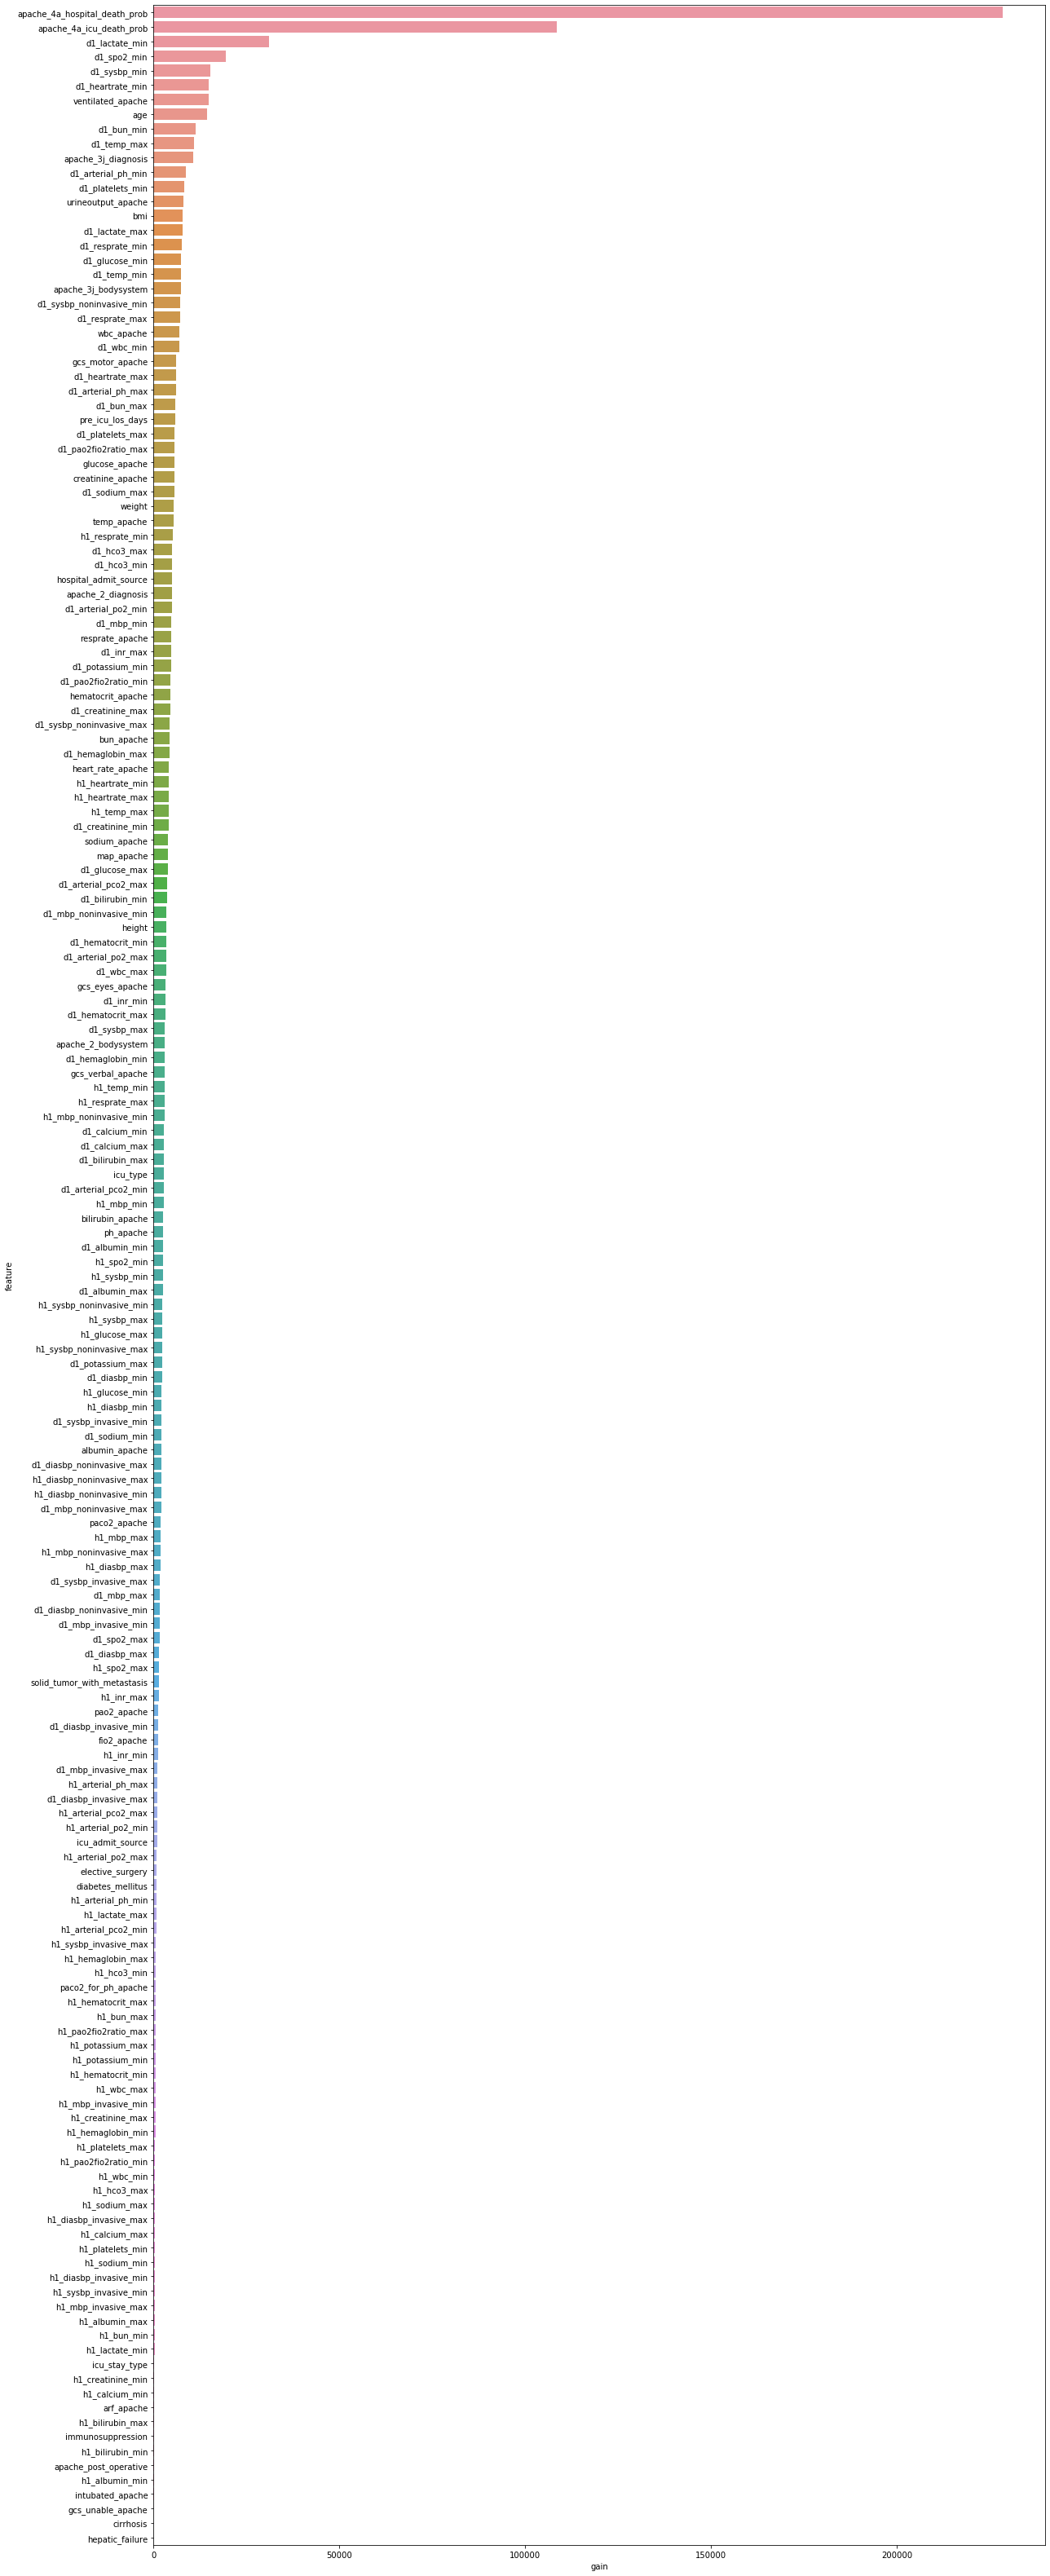

In [38]:
# Plot Feat Importance

imp_df_v2 = pd.DataFrame()
imp_df_v2['feature'] = features
imp_df_v2['gain']  = lgb_model_v2.model.feature_importance(importance_type='gain')
imp_df_v2['split'] = lgb_model_v2.model.feature_importance(importance_type='split')

plot_importances(imp_df_v2)

In [39]:
para aqui

qual dos modelos foi melhor?

SyntaxError: invalid syntax (<ipython-input-39-8126eb9384b4>, line 1)

In [51]:
print('AUC Version 1: ', lgb_model.score)
print('AUC:Version 2: ', lgb_model_v2.score)

AUC Version 1:  0.9073269915680425
AUC:Version 2:  0.9070114492003203


## Submissing File

In [53]:
test["hospital_death"] = lgb_model_v2.y_pred
test[["encounter_id","hospital_death"]].to_csv("submission6-lgb-v4.csv",index=False)

test[["encounter_id","hospital_death"]].head()

,encounter_id,hospital_death
0,2,0.02
1,5,0.02
2,7,0.02
3,8,0.14
4,10,0.76
